## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net, weight_init

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_drop): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=50176, out_features=2560, bias=True)
  (fc2): Linear(in_features=2560, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (fc1_drop): Dropout(p=0.5, inplace=False)
  (fc2_drop): Dropout(p=0.6, inplace=False)
  (conv1_bn):

In [3]:
# download net into GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

net = net.to(device)

cuda


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(112,112),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 20 # 40

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_data_transform = transforms.Compose([Rescale((224,224)),
                                          Normalize(112,112),
                                          ToTensor()])
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                      root_dir='data/test/',       
                                      transform=test_data_transform)

In [8]:
# load test data in batches
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True, 
                         num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    # switch to eval mode
    net.eval()
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints'].to(device)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        images = images.to(device)
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

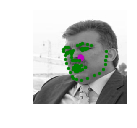

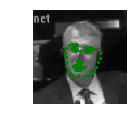

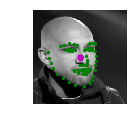

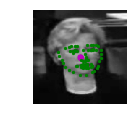

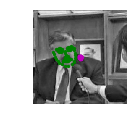

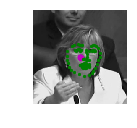

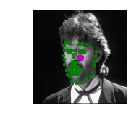

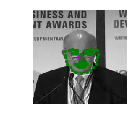

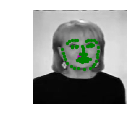

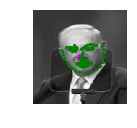

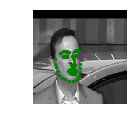

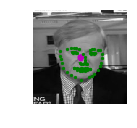

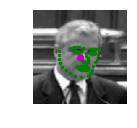

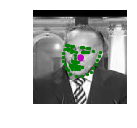

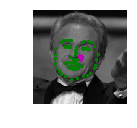

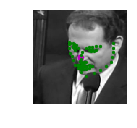

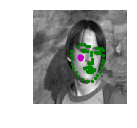

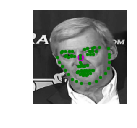

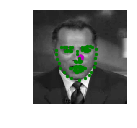

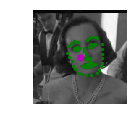

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(5, batch_size/5, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*112+112
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*112+112
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images.cpu(), test_outputs.cpu(), gt_pts.cpu(), batch_size)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

# criterion = nn.L1Loss()
criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr = 0.02, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr = 0.01)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):    
    # list of epoch loss
    list_epoch_loss = []
    list_epoch_loss_test = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        epoch_loss = 0.0
        
        epoch_loss_test = 0.0
        
        # prepare the net for training
        net.train()
        
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            # download variables to device
            images = images.to(device)
            key_pts = key_pts.to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            epoch_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                running_loss /= (10*batch_size)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss))
                running_loss = 0.0
                
        # append epoch loss to list
        list_epoch_loss.append(epoch_loss/(batch_size*len(train_loader)))
        
        # test
        net.eval()
        
        # test data
        for batch_i, data in enumerate(test_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            # download variables to device
            images = images.to(device)
            key_pts = key_pts.to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # update loss statistics
            epoch_loss_test += loss.item()
                
        # append epoch loss to list
        list_epoch_loss_test.append(epoch_loss_test/(batch_size*len(test_loader)))
        print('On Test Data Epoch: {}, Avg. Loss: {}'.format(
            epoch + 1, epoch_loss_test/(batch_size*len(test_loader))))

    print('Finished Training')
    
    return list_epoch_loss, list_epoch_loss_test


In [15]:
# train your network
n_epochs = 800 # start small, and increase when you've decided on your model structure and hyperparams

# training is faster without weight initialization
# net.apply(weight_init) # init weights
import time
start_time = time.time()
list_epoch_loss, list_epoch_loss_test = train_net(n_epochs)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch: 1, Batch: 10, Avg. Loss: 0.004532378874719143
Epoch: 1, Batch: 20, Avg. Loss: 0.0034210205078125
Epoch: 1, Batch: 30, Avg. Loss: 0.002848126795142889
Epoch: 1, Batch: 40, Avg. Loss: 0.0024875427782535555
Epoch: 1, Batch: 50, Avg. Loss: 0.0023515333607792856
Epoch: 1, Batch: 60, Avg. Loss: 0.002316658217459917
Epoch: 1, Batch: 70, Avg. Loss: 0.002728026527911425
Epoch: 1, Batch: 80, Avg. Loss: 0.002455285210162401
Epoch: 1, Batch: 90, Avg. Loss: 0.002331705801188946
Epoch: 1, Batch: 100, Avg. Loss: 0.0018109358847141267
Epoch: 1, Batch: 110, Avg. Loss: 0.0022634657099843023
Epoch: 1, Batch: 120, Avg. Loss: 0.0018046083766967058
Epoch: 1, Batch: 130, Avg. Loss: 0.0022101799212396146
Epoch: 1, Batch: 140, Avg. Loss: 0.001995124500244856
Epoch: 1, Batch: 150, Avg. Loss: 0.0022528759576380254
Epoch: 1, Batch: 160, Avg. Loss: 0.0018707832787185907
Epoch: 1, Batch: 170, Avg. Loss: 0.001996182994917035
On Test Data Epoch: 1, Avg. Loss: 0.0005479752766684844
Epoch: 2, Batch: 10, Avg. Los

Epoch: 9, Batch: 80, Avg. Loss: 0.0008135699527338147
Epoch: 9, Batch: 90, Avg. Loss: 0.0012898137187585235
Epoch: 9, Batch: 100, Avg. Loss: 0.0007805893337354064
Epoch: 9, Batch: 110, Avg. Loss: 0.0008039245754480361
Epoch: 9, Batch: 120, Avg. Loss: 0.0007049557007849217
Epoch: 9, Batch: 130, Avg. Loss: 0.0007510227058082819
Epoch: 9, Batch: 140, Avg. Loss: 0.0012002034857869148
Epoch: 9, Batch: 150, Avg. Loss: 0.0007277809362858533
Epoch: 9, Batch: 160, Avg. Loss: 0.0015575016196817159
Epoch: 9, Batch: 170, Avg. Loss: 0.000760263353586197
On Test Data Epoch: 9, Avg. Loss: 0.00028353305145477256
Epoch: 10, Batch: 10, Avg. Loss: 0.0007681248849257826
Epoch: 10, Batch: 20, Avg. Loss: 0.0006183947436511517
Epoch: 10, Batch: 30, Avg. Loss: 0.0007259708223864436
Epoch: 10, Batch: 40, Avg. Loss: 0.0007820274727419019
Epoch: 10, Batch: 50, Avg. Loss: 0.0009341978561133147
Epoch: 10, Batch: 60, Avg. Loss: 0.0009344019927084446
Epoch: 10, Batch: 70, Avg. Loss: 0.0007488522259518504
Epoch: 10, 

Epoch: 17, Batch: 120, Avg. Loss: 0.0006641008309088648
Epoch: 17, Batch: 130, Avg. Loss: 0.0005969939241185784
Epoch: 17, Batch: 140, Avg. Loss: 0.000580947739072144
Epoch: 17, Batch: 150, Avg. Loss: 0.0006045887665823102
Epoch: 17, Batch: 160, Avg. Loss: 0.0007248496264219284
Epoch: 17, Batch: 170, Avg. Loss: 0.0004909388744272292
On Test Data Epoch: 17, Avg. Loss: 0.00021474565086790766
Epoch: 18, Batch: 10, Avg. Loss: 0.0006778013473376632
Epoch: 18, Batch: 20, Avg. Loss: 0.0004546391149051487
Epoch: 18, Batch: 30, Avg. Loss: 0.0006797152804210782
Epoch: 18, Batch: 40, Avg. Loss: 0.0005269598565064371
Epoch: 18, Batch: 50, Avg. Loss: 0.0004924554214812816
Epoch: 18, Batch: 60, Avg. Loss: 0.000467114036437124
Epoch: 18, Batch: 70, Avg. Loss: 0.0005170444771647454
Epoch: 18, Batch: 80, Avg. Loss: 0.0005893738381564617
Epoch: 18, Batch: 90, Avg. Loss: 0.0005507311061955988
Epoch: 18, Batch: 100, Avg. Loss: 0.0005467763263732195
Epoch: 18, Batch: 110, Avg. Loss: 0.000624250527471304
Ep

Epoch: 25, Batch: 160, Avg. Loss: 0.0004938779212534428
Epoch: 25, Batch: 170, Avg. Loss: 0.0007017621002160013
On Test Data Epoch: 25, Avg. Loss: 0.00016984708834057435
Epoch: 26, Batch: 10, Avg. Loss: 0.0005121998582035303
Epoch: 26, Batch: 20, Avg. Loss: 0.0004851500014774501
Epoch: 26, Batch: 30, Avg. Loss: 0.0003998809563927352
Epoch: 26, Batch: 40, Avg. Loss: 0.0005216165701858699
Epoch: 26, Batch: 50, Avg. Loss: 0.0003785896440967917
Epoch: 26, Batch: 60, Avg. Loss: 0.0005598579533398152
Epoch: 26, Batch: 70, Avg. Loss: 0.000751275212969631
Epoch: 26, Batch: 80, Avg. Loss: 0.0004563794983550906
Epoch: 26, Batch: 90, Avg. Loss: 0.00038052206626161935
Epoch: 26, Batch: 100, Avg. Loss: 0.0004935780423693358
Epoch: 26, Batch: 110, Avg. Loss: 0.00038879806641489267
Epoch: 26, Batch: 120, Avg. Loss: 0.0004820393305271864
Epoch: 26, Batch: 130, Avg. Loss: 0.00047431131126359107
Epoch: 26, Batch: 140, Avg. Loss: 0.0004590175277553499
Epoch: 26, Batch: 150, Avg. Loss: 0.00047907164553180

Epoch: 34, Batch: 10, Avg. Loss: 0.00040200067684054375
Epoch: 34, Batch: 20, Avg. Loss: 0.0004005376878194511
Epoch: 34, Batch: 30, Avg. Loss: 0.0004186941916123033
Epoch: 34, Batch: 40, Avg. Loss: 0.0004379088059067726
Epoch: 34, Batch: 50, Avg. Loss: 0.00033439424820244315
Epoch: 34, Batch: 60, Avg. Loss: 0.00041775710415095093
Epoch: 34, Batch: 70, Avg. Loss: 0.00036951748421415687
Epoch: 34, Batch: 80, Avg. Loss: 0.00038608479546383025
Epoch: 34, Batch: 90, Avg. Loss: 0.0004071823554113507
Epoch: 34, Batch: 100, Avg. Loss: 0.0006668064719997347
Epoch: 34, Batch: 110, Avg. Loss: 0.0004086552443914115
Epoch: 34, Batch: 120, Avg. Loss: 0.0003546400205232203
Epoch: 34, Batch: 130, Avg. Loss: 0.000503770171198994
Epoch: 34, Batch: 140, Avg. Loss: 0.00036541136680170896
Epoch: 34, Batch: 150, Avg. Loss: 0.0003383442759513855
Epoch: 34, Batch: 160, Avg. Loss: 0.0003921583853662014
Epoch: 34, Batch: 170, Avg. Loss: 0.0007693204306997358
On Test Data Epoch: 34, Avg. Loss: 0.000153067587421

Epoch: 42, Batch: 40, Avg. Loss: 0.00030491778394207356
Epoch: 42, Batch: 50, Avg. Loss: 0.0003192499442957342
Epoch: 42, Batch: 60, Avg. Loss: 0.0003108930983580649
Epoch: 42, Batch: 70, Avg. Loss: 0.0003291566320694983
Epoch: 42, Batch: 80, Avg. Loss: 0.0005936441314406693
Epoch: 42, Batch: 90, Avg. Loss: 0.0007420108886435628
Epoch: 42, Batch: 100, Avg. Loss: 0.00028730809921398757
Epoch: 42, Batch: 110, Avg. Loss: 0.0003221776685677469
Epoch: 42, Batch: 120, Avg. Loss: 0.00030031767673790457
Epoch: 42, Batch: 130, Avg. Loss: 0.0003437111573293805
Epoch: 42, Batch: 140, Avg. Loss: 0.0003139741695486009
Epoch: 42, Batch: 150, Avg. Loss: 0.0003615320799872279
Epoch: 42, Batch: 160, Avg. Loss: 0.00035852833883836865
Epoch: 42, Batch: 170, Avg. Loss: 0.000368737040553242
On Test Data Epoch: 42, Avg. Loss: 0.00014494776260107756
Epoch: 43, Batch: 10, Avg. Loss: 0.0003180720447562635
Epoch: 43, Batch: 20, Avg. Loss: 0.0003326382429804653
Epoch: 43, Batch: 30, Avg. Loss: 0.0003805690060835

Epoch: 50, Batch: 70, Avg. Loss: 0.000307318433187902
Epoch: 50, Batch: 80, Avg. Loss: 0.000284002092666924
Epoch: 50, Batch: 90, Avg. Loss: 0.000291895957197994
Epoch: 50, Batch: 100, Avg. Loss: 0.00034822144312784075
Epoch: 50, Batch: 110, Avg. Loss: 0.0003686127613764256
Epoch: 50, Batch: 120, Avg. Loss: 0.000522316019050777
Epoch: 50, Batch: 130, Avg. Loss: 0.00030971125001087783
Epoch: 50, Batch: 140, Avg. Loss: 0.00038944347528740763
Epoch: 50, Batch: 150, Avg. Loss: 0.00030177821405231954
Epoch: 50, Batch: 160, Avg. Loss: 0.00031362315639853476
Epoch: 50, Batch: 170, Avg. Loss: 0.00035909051075577736
On Test Data Epoch: 50, Avg. Loss: 0.00013125550989897397
Epoch: 51, Batch: 10, Avg. Loss: 0.00031053264159709216
Epoch: 51, Batch: 20, Avg. Loss: 0.0003446948388591409
Epoch: 51, Batch: 30, Avg. Loss: 0.0006135633226949721
Epoch: 51, Batch: 40, Avg. Loss: 0.0003032330353744328
Epoch: 51, Batch: 50, Avg. Loss: 0.00033153674798086285
Epoch: 51, Batch: 60, Avg. Loss: 0.000308631439693

Epoch: 58, Batch: 100, Avg. Loss: 0.00029408894944936035
Epoch: 58, Batch: 110, Avg. Loss: 0.00029487609630450605
Epoch: 58, Batch: 120, Avg. Loss: 0.0002865009324159473
Epoch: 58, Batch: 130, Avg. Loss: 0.00033281404757872223
Epoch: 58, Batch: 140, Avg. Loss: 0.00040013441117480396
Epoch: 58, Batch: 150, Avg. Loss: 0.00048457906697876754
Epoch: 58, Batch: 160, Avg. Loss: 0.0004459965950809419
Epoch: 58, Batch: 170, Avg. Loss: 0.00033443766180425884
On Test Data Epoch: 58, Avg. Loss: 0.00012758998946549419
Epoch: 59, Batch: 10, Avg. Loss: 0.000298348490614444
Epoch: 59, Batch: 20, Avg. Loss: 0.00029019754845649004
Epoch: 59, Batch: 30, Avg. Loss: 0.0003100004547741264
Epoch: 59, Batch: 40, Avg. Loss: 0.00040056029101833703
Epoch: 59, Batch: 50, Avg. Loss: 0.00032421316718682646
Epoch: 59, Batch: 60, Avg. Loss: 0.0003092194744385779
Epoch: 59, Batch: 70, Avg. Loss: 0.0004374803975224495
Epoch: 59, Batch: 80, Avg. Loss: 0.0003732163831591606
Epoch: 59, Batch: 90, Avg. Loss: 0.00037840523

Epoch: 66, Batch: 130, Avg. Loss: 0.0007607997488230467
Epoch: 66, Batch: 140, Avg. Loss: 0.0003381810057908297
Epoch: 66, Batch: 150, Avg. Loss: 0.00028144774027168753
Epoch: 66, Batch: 160, Avg. Loss: 0.00030521671404130755
Epoch: 66, Batch: 170, Avg. Loss: 0.00031631514662876724
On Test Data Epoch: 66, Avg. Loss: 0.00012354490508397037
Epoch: 67, Batch: 10, Avg. Loss: 0.0005038072518073022
Epoch: 67, Batch: 20, Avg. Loss: 0.0002650024276226759
Epoch: 67, Batch: 30, Avg. Loss: 0.00028266708250157535
Epoch: 67, Batch: 40, Avg. Loss: 0.0002837237319909036
Epoch: 67, Batch: 50, Avg. Loss: 0.00027138087432831525
Epoch: 67, Batch: 60, Avg. Loss: 0.0002476904075592756
Epoch: 67, Batch: 70, Avg. Loss: 0.00034027860267087817
Epoch: 67, Batch: 80, Avg. Loss: 0.00028958185110241176
Epoch: 67, Batch: 90, Avg. Loss: 0.0002814835961908102
Epoch: 67, Batch: 100, Avg. Loss: 0.00029869642457924783
Epoch: 67, Batch: 110, Avg. Loss: 0.0002751435583923012
Epoch: 67, Batch: 120, Avg. Loss: 0.00022930876

Epoch: 74, Batch: 160, Avg. Loss: 0.0004529991548042744
Epoch: 74, Batch: 170, Avg. Loss: 0.0002685088128782809
On Test Data Epoch: 74, Avg. Loss: 0.00012716765452821095
Epoch: 75, Batch: 10, Avg. Loss: 0.00028810359188355503
Epoch: 75, Batch: 20, Avg. Loss: 0.0002620553784072399
Epoch: 75, Batch: 30, Avg. Loss: 0.00037948195938952267
Epoch: 75, Batch: 40, Avg. Loss: 0.00025737222866155206
Epoch: 75, Batch: 50, Avg. Loss: 0.0002628820389509201
Epoch: 75, Batch: 60, Avg. Loss: 0.00028031595633365214
Epoch: 75, Batch: 70, Avg. Loss: 0.0002904414292424917
Epoch: 75, Batch: 80, Avg. Loss: 0.00029228772153146567
Epoch: 75, Batch: 90, Avg. Loss: 0.0005124531965702773
Epoch: 75, Batch: 100, Avg. Loss: 0.0002615082974079996
Epoch: 75, Batch: 110, Avg. Loss: 0.00028198011917993424
Epoch: 75, Batch: 120, Avg. Loss: 0.0003042705520056188
Epoch: 75, Batch: 130, Avg. Loss: 0.0002442857762798667
Epoch: 75, Batch: 140, Avg. Loss: 0.0003034925856627524
Epoch: 75, Batch: 150, Avg. Loss: 0.0002460457640

Epoch: 83, Batch: 10, Avg. Loss: 0.00024147427640855312
Epoch: 83, Batch: 20, Avg. Loss: 0.00031845374731346963
Epoch: 83, Batch: 30, Avg. Loss: 0.00030342231271788476
Epoch: 83, Batch: 40, Avg. Loss: 0.0002280243905261159
Epoch: 83, Batch: 50, Avg. Loss: 0.00023693962721154093
Epoch: 83, Batch: 60, Avg. Loss: 0.0002955505915451795
Epoch: 83, Batch: 70, Avg. Loss: 0.00024265539832413197
Epoch: 83, Batch: 80, Avg. Loss: 0.00021645676693879068
Epoch: 83, Batch: 90, Avg. Loss: 0.0002479969302657992
Epoch: 83, Batch: 100, Avg. Loss: 0.00022723919129930437
Epoch: 83, Batch: 110, Avg. Loss: 0.00022850503795780242
Epoch: 83, Batch: 120, Avg. Loss: 0.00022632967331446708
Epoch: 83, Batch: 130, Avg. Loss: 0.0002573908772319555
Epoch: 83, Batch: 140, Avg. Loss: 0.00026603860431350767
Epoch: 83, Batch: 150, Avg. Loss: 0.00030116073321551085
Epoch: 83, Batch: 160, Avg. Loss: 0.00022288123262114822
Epoch: 83, Batch: 170, Avg. Loss: 0.00022844678140245377
On Test Data Epoch: 83, Avg. Loss: 0.0001120

Epoch: 91, Batch: 30, Avg. Loss: 0.00031492502195760606
Epoch: 91, Batch: 40, Avg. Loss: 0.0002312113717198372
Epoch: 91, Batch: 50, Avg. Loss: 0.0002520059852395207
Epoch: 91, Batch: 60, Avg. Loss: 0.00023462914396077394
Epoch: 91, Batch: 70, Avg. Loss: 0.0002452490048017353
Epoch: 91, Batch: 80, Avg. Loss: 0.00027366337832063437
Epoch: 91, Batch: 90, Avg. Loss: 0.000533347581513226
Epoch: 91, Batch: 100, Avg. Loss: 0.0002057503641117364
Epoch: 91, Batch: 110, Avg. Loss: 0.000257839149562642
Epoch: 91, Batch: 120, Avg. Loss: 0.000259336915332824
Epoch: 91, Batch: 130, Avg. Loss: 0.00024532360956072805
Epoch: 91, Batch: 140, Avg. Loss: 0.0002712910308036953
Epoch: 91, Batch: 150, Avg. Loss: 0.000263900380814448
Epoch: 91, Batch: 160, Avg. Loss: 0.0002308981295209378
Epoch: 91, Batch: 170, Avg. Loss: 0.00023106147185899317
On Test Data Epoch: 91, Avg. Loss: 0.00010678051323152315
Epoch: 92, Batch: 10, Avg. Loss: 0.00024403748917393387
Epoch: 92, Batch: 20, Avg. Loss: 0.00020673295948654

Epoch: 99, Batch: 50, Avg. Loss: 0.00023248292971402406
Epoch: 99, Batch: 60, Avg. Loss: 0.000230646199779585
Epoch: 99, Batch: 70, Avg. Loss: 0.00018977159284986556
Epoch: 99, Batch: 80, Avg. Loss: 0.0002074653166346252
Epoch: 99, Batch: 90, Avg. Loss: 0.00019820133340544999
Epoch: 99, Batch: 100, Avg. Loss: 0.0003914977563545108
Epoch: 99, Batch: 110, Avg. Loss: 0.00025805620243772863
Epoch: 99, Batch: 120, Avg. Loss: 0.00021070818649604917
Epoch: 99, Batch: 130, Avg. Loss: 0.00032047849730588497
Epoch: 99, Batch: 140, Avg. Loss: 0.0002785408252384514
Epoch: 99, Batch: 150, Avg. Loss: 0.0002344521984923631
Epoch: 99, Batch: 160, Avg. Loss: 0.00021285075694322587
Epoch: 99, Batch: 170, Avg. Loss: 0.00022560345707461237
On Test Data Epoch: 99, Avg. Loss: 0.0001019097021363007
Epoch: 100, Batch: 10, Avg. Loss: 0.00024534666328690947
Epoch: 100, Batch: 20, Avg. Loss: 0.00023250937811098994
Epoch: 100, Batch: 30, Avg. Loss: 0.00025995581527240577
Epoch: 100, Batch: 40, Avg. Loss: 0.000206

Epoch: 107, Batch: 50, Avg. Loss: 0.0002509604685474187
Epoch: 107, Batch: 60, Avg. Loss: 0.00019788151606917382
Epoch: 107, Batch: 70, Avg. Loss: 0.00024210664676502347
Epoch: 107, Batch: 80, Avg. Loss: 0.00022117617074400188
Epoch: 107, Batch: 90, Avg. Loss: 0.0001966273714788258
Epoch: 107, Batch: 100, Avg. Loss: 0.00018811871646903455
Epoch: 107, Batch: 110, Avg. Loss: 0.00020495878532528878
Epoch: 107, Batch: 120, Avg. Loss: 0.00023527537239715458
Epoch: 107, Batch: 130, Avg. Loss: 0.00018505827756598592
Epoch: 107, Batch: 140, Avg. Loss: 0.00019018817460164428
Epoch: 107, Batch: 150, Avg. Loss: 0.00019776580622419716
Epoch: 107, Batch: 160, Avg. Loss: 0.00024997817585244777
Epoch: 107, Batch: 170, Avg. Loss: 0.0002217984909657389
On Test Data Epoch: 107, Avg. Loss: 9.854066988620429e-05
Epoch: 108, Batch: 10, Avg. Loss: 0.00019682763959281147
Epoch: 108, Batch: 20, Avg. Loss: 0.00018461512983776628
Epoch: 108, Batch: 30, Avg. Loss: 0.0002040803653653711
Epoch: 108, Batch: 40, Avg

Epoch: 115, Batch: 50, Avg. Loss: 0.00019847586168907582
Epoch: 115, Batch: 60, Avg. Loss: 0.00019589293748140335
Epoch: 115, Batch: 70, Avg. Loss: 0.00019305281224660576
Epoch: 115, Batch: 80, Avg. Loss: 0.000226821715477854
Epoch: 115, Batch: 90, Avg. Loss: 0.0001725557167083025
Epoch: 115, Batch: 100, Avg. Loss: 0.0001836581458337605
Epoch: 115, Batch: 110, Avg. Loss: 0.00022910497733391822
Epoch: 115, Batch: 120, Avg. Loss: 0.000181896910071373
Epoch: 115, Batch: 130, Avg. Loss: 0.00029993094736710193
Epoch: 115, Batch: 140, Avg. Loss: 0.00023848036187700927
Epoch: 115, Batch: 150, Avg. Loss: 0.0002154003328178078
Epoch: 115, Batch: 160, Avg. Loss: 0.0004007942299358547
Epoch: 115, Batch: 170, Avg. Loss: 0.0002226602821610868
On Test Data Epoch: 115, Avg. Loss: 9.932278309208461e-05
Epoch: 116, Batch: 10, Avg. Loss: 0.00021821571863256395
Epoch: 116, Batch: 20, Avg. Loss: 0.00023906467366032301
Epoch: 116, Batch: 30, Avg. Loss: 0.00022390574566088616
Epoch: 116, Batch: 40, Avg. Los

Epoch: 123, Batch: 50, Avg. Loss: 0.0002045167807955295
Epoch: 123, Batch: 60, Avg. Loss: 0.0002525737346149981
Epoch: 123, Batch: 70, Avg. Loss: 0.00020777063211426138
Epoch: 123, Batch: 80, Avg. Loss: 0.00018183002131991088
Epoch: 123, Batch: 90, Avg. Loss: 0.00020563989295624196
Epoch: 123, Batch: 100, Avg. Loss: 0.0001843019190710038
Epoch: 123, Batch: 110, Avg. Loss: 0.00024371397448703648
Epoch: 123, Batch: 120, Avg. Loss: 0.00020796404220163822
Epoch: 123, Batch: 130, Avg. Loss: 0.00020583381527103484
Epoch: 123, Batch: 140, Avg. Loss: 0.00019220720161683858
Epoch: 123, Batch: 150, Avg. Loss: 0.0002013223012909293
Epoch: 123, Batch: 160, Avg. Loss: 0.00019019903847947717
Epoch: 123, Batch: 170, Avg. Loss: 0.0002063919766806066
On Test Data Epoch: 123, Avg. Loss: 9.210364675173201e-05
Epoch: 124, Batch: 10, Avg. Loss: 0.00018891627667471766
Epoch: 124, Batch: 20, Avg. Loss: 0.00018395236576907337
Epoch: 124, Batch: 30, Avg. Loss: 0.00018591351457871496
Epoch: 124, Batch: 40, Avg.

Epoch: 131, Batch: 50, Avg. Loss: 0.00018379611079581083
Epoch: 131, Batch: 60, Avg. Loss: 0.00019975545932538808
Epoch: 131, Batch: 70, Avg. Loss: 0.00025125930085778236
Epoch: 131, Batch: 80, Avg. Loss: 0.00025174060370773075
Epoch: 131, Batch: 90, Avg. Loss: 0.00024878671392798425
Epoch: 131, Batch: 100, Avg. Loss: 0.00018860173062421382
Epoch: 131, Batch: 110, Avg. Loss: 0.00019512022729031742
Epoch: 131, Batch: 120, Avg. Loss: 0.00020593590103089809
Epoch: 131, Batch: 130, Avg. Loss: 0.00019970790133811534
Epoch: 131, Batch: 140, Avg. Loss: 0.0001715753262396902
Epoch: 131, Batch: 150, Avg. Loss: 0.00024383342009969054
Epoch: 131, Batch: 160, Avg. Loss: 0.00020242905826307834
Epoch: 131, Batch: 170, Avg. Loss: 0.0002053846709895879
On Test Data Epoch: 131, Avg. Loss: 9.490942227272077e-05
Epoch: 132, Batch: 10, Avg. Loss: 0.00018136787926778197
Epoch: 132, Batch: 20, Avg. Loss: 0.00020379781606607138
Epoch: 132, Batch: 30, Avg. Loss: 0.00018027253565378488
Epoch: 132, Batch: 40, A

Epoch: 139, Batch: 50, Avg. Loss: 0.00020588089595548808
Epoch: 139, Batch: 60, Avg. Loss: 0.00025463824975304307
Epoch: 139, Batch: 70, Avg. Loss: 0.00021046759909950196
Epoch: 139, Batch: 80, Avg. Loss: 0.00022318254341371357
Epoch: 139, Batch: 90, Avg. Loss: 0.0002086451440118253
Epoch: 139, Batch: 100, Avg. Loss: 0.0002436047524679452
Epoch: 139, Batch: 110, Avg. Loss: 0.00020738986902870237
Epoch: 139, Batch: 120, Avg. Loss: 0.00020850031287409366
Epoch: 139, Batch: 130, Avg. Loss: 0.00020464896108023822
Epoch: 139, Batch: 140, Avg. Loss: 0.0002038060873746872
Epoch: 139, Batch: 150, Avg. Loss: 0.0001631713006645441
Epoch: 139, Batch: 160, Avg. Loss: 0.00020890009589493274
Epoch: 139, Batch: 170, Avg. Loss: 0.0002572980790864676
On Test Data Epoch: 139, Avg. Loss: 9.144932525650336e-05
Epoch: 140, Batch: 10, Avg. Loss: 0.00018309336621314288
Epoch: 140, Batch: 20, Avg. Loss: 0.00020426467875950038
Epoch: 140, Batch: 30, Avg. Loss: 0.0002184646890964359
Epoch: 140, Batch: 40, Avg. 

Epoch: 147, Batch: 50, Avg. Loss: 0.00015679150470532477
Epoch: 147, Batch: 60, Avg. Loss: 0.00016170889488421381
Epoch: 147, Batch: 70, Avg. Loss: 0.00019676189636811615
Epoch: 147, Batch: 80, Avg. Loss: 0.00019561454304493962
Epoch: 147, Batch: 90, Avg. Loss: 0.00020068223820999265
Epoch: 147, Batch: 100, Avg. Loss: 0.00023195026558823885
Epoch: 147, Batch: 110, Avg. Loss: 0.00018180212704464792
Epoch: 147, Batch: 120, Avg. Loss: 0.0001890854851808399
Epoch: 147, Batch: 130, Avg. Loss: 0.00017024673172272742
Epoch: 147, Batch: 140, Avg. Loss: 0.0001837832643650472
Epoch: 147, Batch: 150, Avg. Loss: 0.00017813417711295187
Epoch: 147, Batch: 160, Avg. Loss: 0.00017905184184201063
Epoch: 147, Batch: 170, Avg. Loss: 0.0002303631918039173
On Test Data Epoch: 147, Avg. Loss: 8.691625732283752e-05
Epoch: 148, Batch: 10, Avg. Loss: 0.0001797073392663151
Epoch: 148, Batch: 20, Avg. Loss: 0.00017266790149733424
Epoch: 148, Batch: 30, Avg. Loss: 0.00020136090926826
Epoch: 148, Batch: 40, Avg. L

Epoch: 155, Batch: 50, Avg. Loss: 0.00021444162935949863
Epoch: 155, Batch: 60, Avg. Loss: 0.0001757095055654645
Epoch: 155, Batch: 70, Avg. Loss: 0.00016967982286587358
Epoch: 155, Batch: 80, Avg. Loss: 0.00021206787205301224
Epoch: 155, Batch: 90, Avg. Loss: 0.00017968492000363767
Epoch: 155, Batch: 100, Avg. Loss: 0.00016514247981831432
Epoch: 155, Batch: 110, Avg. Loss: 0.0001860999455675483
Epoch: 155, Batch: 120, Avg. Loss: 0.00018148843897506595
Epoch: 155, Batch: 130, Avg. Loss: 0.00019967352040112018
Epoch: 155, Batch: 140, Avg. Loss: 0.0002006256254389882
Epoch: 155, Batch: 150, Avg. Loss: 0.00017606232315301896
Epoch: 155, Batch: 160, Avg. Loss: 0.00016676520695909857
Epoch: 155, Batch: 170, Avg. Loss: 0.00016777323908172547
On Test Data Epoch: 155, Avg. Loss: 8.283100756577766e-05
Epoch: 156, Batch: 10, Avg. Loss: 0.00017688106163404882
Epoch: 156, Batch: 20, Avg. Loss: 0.0001610472402535379
Epoch: 156, Batch: 30, Avg. Loss: 0.00018859018571674825
Epoch: 156, Batch: 40, Avg

Epoch: 163, Batch: 50, Avg. Loss: 0.00017858242848888038
Epoch: 163, Batch: 60, Avg. Loss: 0.0002061767119448632
Epoch: 163, Batch: 70, Avg. Loss: 0.00021214962587691843
Epoch: 163, Batch: 80, Avg. Loss: 0.00017676415503956378
Epoch: 163, Batch: 90, Avg. Loss: 0.00018230563728138804
Epoch: 163, Batch: 100, Avg. Loss: 0.0001462885655928403
Epoch: 163, Batch: 110, Avg. Loss: 0.00016012404346838594
Epoch: 163, Batch: 120, Avg. Loss: 0.00015234818099997937
Epoch: 163, Batch: 130, Avg. Loss: 0.00018278809147886932
Epoch: 163, Batch: 140, Avg. Loss: 0.00015955064329318703
Epoch: 163, Batch: 150, Avg. Loss: 0.00016204690095037222
Epoch: 163, Batch: 160, Avg. Loss: 0.00016524060280062258
Epoch: 163, Batch: 170, Avg. Loss: 0.00018354151630774142
On Test Data Epoch: 163, Avg. Loss: 8.271833798155571e-05
Epoch: 164, Batch: 10, Avg. Loss: 0.00022050846368074417
Epoch: 164, Batch: 20, Avg. Loss: 0.00016163921914994717
Epoch: 164, Batch: 30, Avg. Loss: 0.00016883916803635656
Epoch: 164, Batch: 40, A

Epoch: 171, Batch: 50, Avg. Loss: 0.00016703454544767738
Epoch: 171, Batch: 60, Avg. Loss: 0.00015643545659258963
Epoch: 171, Batch: 70, Avg. Loss: 0.00016979459091089665
Epoch: 171, Batch: 80, Avg. Loss: 0.000166285015293397
Epoch: 171, Batch: 90, Avg. Loss: 0.00014718667953275144
Epoch: 171, Batch: 100, Avg. Loss: 0.00018041088245809077
Epoch: 171, Batch: 110, Avg. Loss: 0.00016374721191823483
Epoch: 171, Batch: 120, Avg. Loss: 0.00015916892327368258
Epoch: 171, Batch: 130, Avg. Loss: 0.0001728023577015847
Epoch: 171, Batch: 140, Avg. Loss: 0.0002975167252589017
Epoch: 171, Batch: 150, Avg. Loss: 0.00020386874442920088
Epoch: 171, Batch: 160, Avg. Loss: 0.00018370996578596533
Epoch: 171, Batch: 170, Avg. Loss: 0.00019647630862891673
On Test Data Epoch: 171, Avg. Loss: 8.324019831772416e-05
Epoch: 172, Batch: 10, Avg. Loss: 0.00015668324776925148
Epoch: 172, Batch: 20, Avg. Loss: 0.00022173902834765613
Epoch: 172, Batch: 30, Avg. Loss: 0.0001598527131136507
Epoch: 172, Batch: 40, Avg.

Epoch: 179, Batch: 50, Avg. Loss: 0.00015360659337602557
Epoch: 179, Batch: 60, Avg. Loss: 0.00016018243390135466
Epoch: 179, Batch: 70, Avg. Loss: 0.00018070692545734345
Epoch: 179, Batch: 80, Avg. Loss: 0.0001861714175902307
Epoch: 179, Batch: 90, Avg. Loss: 0.00016473183874040842
Epoch: 179, Batch: 100, Avg. Loss: 0.00015631559304893016
Epoch: 179, Batch: 110, Avg. Loss: 0.00018730912008322776
Epoch: 179, Batch: 120, Avg. Loss: 0.00017187941237352787
Epoch: 179, Batch: 130, Avg. Loss: 0.00018203189945779742
Epoch: 179, Batch: 140, Avg. Loss: 0.00015389483538456262
Epoch: 179, Batch: 150, Avg. Loss: 0.00028390125371515753
Epoch: 179, Batch: 160, Avg. Loss: 0.00018023381126113235
Epoch: 179, Batch: 170, Avg. Loss: 0.00023065386805683373
On Test Data Epoch: 179, Avg. Loss: 9.188323926467162e-05
Epoch: 180, Batch: 10, Avg. Loss: 0.00015551879885606468
Epoch: 180, Batch: 20, Avg. Loss: 0.00016294387052766978
Epoch: 180, Batch: 30, Avg. Loss: 0.0001529005344491452
Epoch: 180, Batch: 40, A

Epoch: 187, Batch: 50, Avg. Loss: 0.00020669720252044498
Epoch: 187, Batch: 60, Avg. Loss: 0.00016608376405201851
Epoch: 187, Batch: 70, Avg. Loss: 0.00014423549408093094
Epoch: 187, Batch: 80, Avg. Loss: 0.00016073419246822595
Epoch: 187, Batch: 90, Avg. Loss: 0.00015945573570206762
Epoch: 187, Batch: 100, Avg. Loss: 0.0003471001889556646
Epoch: 187, Batch: 110, Avg. Loss: 0.00018578993855044245
Epoch: 187, Batch: 120, Avg. Loss: 0.0001684368960559368
Epoch: 187, Batch: 130, Avg. Loss: 0.00013857405516318978
Epoch: 187, Batch: 140, Avg. Loss: 0.0001773392816539854
Epoch: 187, Batch: 150, Avg. Loss: 0.00018963526468724013
Epoch: 187, Batch: 160, Avg. Loss: 0.00017277836683206262
Epoch: 187, Batch: 170, Avg. Loss: 0.00017189062666147947
On Test Data Epoch: 187, Avg. Loss: 8.810053994425405e-05
Epoch: 188, Batch: 10, Avg. Loss: 0.00016234585200436413
Epoch: 188, Batch: 20, Avg. Loss: 0.0002116598968859762
Epoch: 188, Batch: 30, Avg. Loss: 0.00019448733306489885
Epoch: 188, Batch: 40, Avg

Epoch: 195, Batch: 50, Avg. Loss: 0.0001578107161913067
Epoch: 195, Batch: 60, Avg. Loss: 0.00015725947800092398
Epoch: 195, Batch: 70, Avg. Loss: 0.00015362345497123896
Epoch: 195, Batch: 80, Avg. Loss: 0.00019902226515114307
Epoch: 195, Batch: 90, Avg. Loss: 0.0001845696638338268
Epoch: 195, Batch: 100, Avg. Loss: 0.00015784491959493606
Epoch: 195, Batch: 110, Avg. Loss: 0.00015294197131879628
Epoch: 195, Batch: 120, Avg. Loss: 0.000139132080366835
Epoch: 195, Batch: 130, Avg. Loss: 0.00016152687661815434
Epoch: 195, Batch: 140, Avg. Loss: 0.00014833516674116253
Epoch: 195, Batch: 150, Avg. Loss: 0.00016146382316946983
Epoch: 195, Batch: 160, Avg. Loss: 0.0001913300110027194
Epoch: 195, Batch: 170, Avg. Loss: 0.0001528411649633199
On Test Data Epoch: 195, Avg. Loss: 7.865790065783912e-05
Epoch: 196, Batch: 10, Avg. Loss: 0.0001790021499618888
Epoch: 196, Batch: 20, Avg. Loss: 0.00014693233417347072
Epoch: 196, Batch: 30, Avg. Loss: 0.0001515085936989635
Epoch: 196, Batch: 40, Avg. Lo

Epoch: 203, Batch: 50, Avg. Loss: 0.0001593250478617847
Epoch: 203, Batch: 60, Avg. Loss: 0.00015590695780701936
Epoch: 203, Batch: 70, Avg. Loss: 0.0001606469415128231
Epoch: 203, Batch: 80, Avg. Loss: 0.0001457457209471613
Epoch: 203, Batch: 90, Avg. Loss: 0.00016615996020846068
Epoch: 203, Batch: 100, Avg. Loss: 0.0002506229223217815
Epoch: 203, Batch: 110, Avg. Loss: 0.00015899671474471687
Epoch: 203, Batch: 120, Avg. Loss: 0.0002047066017985344
Epoch: 203, Batch: 130, Avg. Loss: 0.00019297217368148268
Epoch: 203, Batch: 140, Avg. Loss: 0.00021414029877632855
Epoch: 203, Batch: 150, Avg. Loss: 0.00015877097728662193
Epoch: 203, Batch: 160, Avg. Loss: 0.00019002667861059308
Epoch: 203, Batch: 170, Avg. Loss: 0.0001447543373797089
On Test Data Epoch: 203, Avg. Loss: 7.706285478212895e-05
Epoch: 204, Batch: 10, Avg. Loss: 0.00014764033723622561
Epoch: 204, Batch: 20, Avg. Loss: 0.00014886783435940742
Epoch: 204, Batch: 30, Avg. Loss: 0.00015433865948580205
Epoch: 204, Batch: 40, Avg. 

Epoch: 211, Batch: 50, Avg. Loss: 0.00020800051977857949
Epoch: 211, Batch: 60, Avg. Loss: 0.0001814462128095329
Epoch: 211, Batch: 70, Avg. Loss: 0.0001548860885668546
Epoch: 211, Batch: 80, Avg. Loss: 0.00013419689261354506
Epoch: 211, Batch: 90, Avg. Loss: 0.00016690025455318392
Epoch: 211, Batch: 100, Avg. Loss: 0.00016055813408456744
Epoch: 211, Batch: 110, Avg. Loss: 0.00019726281985640525
Epoch: 211, Batch: 120, Avg. Loss: 0.0001554948859848082
Epoch: 211, Batch: 130, Avg. Loss: 0.00020251620560884475
Epoch: 211, Batch: 140, Avg. Loss: 0.00015904786065220832
Epoch: 211, Batch: 150, Avg. Loss: 0.00017671891138888894
Epoch: 211, Batch: 160, Avg. Loss: 0.00014762362698093057
Epoch: 211, Batch: 170, Avg. Loss: 0.0001654601888731122
On Test Data Epoch: 211, Avg. Loss: 7.702561523705625e-05
Epoch: 212, Batch: 10, Avg. Loss: 0.0004985730932094156
Epoch: 212, Batch: 20, Avg. Loss: 0.00014127092086710035
Epoch: 212, Batch: 30, Avg. Loss: 0.00016611500876024366
Epoch: 212, Batch: 40, Avg.

Epoch: 219, Batch: 50, Avg. Loss: 0.00015270338859409095
Epoch: 219, Batch: 60, Avg. Loss: 0.00015965141355991363
Epoch: 219, Batch: 70, Avg. Loss: 0.00021838749584276228
Epoch: 219, Batch: 80, Avg. Loss: 0.00014998804545029998
Epoch: 219, Batch: 90, Avg. Loss: 0.0001785025658318773
Epoch: 219, Batch: 100, Avg. Loss: 0.00014935843180865048
Epoch: 219, Batch: 110, Avg. Loss: 0.00017560026957653464
Epoch: 219, Batch: 120, Avg. Loss: 0.0001458409719634801
Epoch: 219, Batch: 130, Avg. Loss: 0.0001492136309389025
Epoch: 219, Batch: 140, Avg. Loss: 0.00014940698049031197
Epoch: 219, Batch: 150, Avg. Loss: 0.00016017481684684753
Epoch: 219, Batch: 160, Avg. Loss: 0.000161744502838701
Epoch: 219, Batch: 170, Avg. Loss: 0.00018243170343339442
On Test Data Epoch: 219, Avg. Loss: 7.768420992084802e-05
Epoch: 220, Batch: 10, Avg. Loss: 0.0001362979388795793
Epoch: 220, Batch: 20, Avg. Loss: 0.00014737154415342957
Epoch: 220, Batch: 30, Avg. Loss: 0.00016424678964540362
Epoch: 220, Batch: 40, Avg. 

Epoch: 227, Batch: 50, Avg. Loss: 0.00014611209975555538
Epoch: 227, Batch: 60, Avg. Loss: 0.00014677854371257127
Epoch: 227, Batch: 70, Avg. Loss: 0.0001511624566046521
Epoch: 227, Batch: 80, Avg. Loss: 0.00014615404768846929
Epoch: 227, Batch: 90, Avg. Loss: 0.00015276782331056894
Epoch: 227, Batch: 100, Avg. Loss: 0.00012256631103809923
Epoch: 227, Batch: 110, Avg. Loss: 0.00015222469344735145
Epoch: 227, Batch: 120, Avg. Loss: 0.00018290630425326526
Epoch: 227, Batch: 130, Avg. Loss: 0.00014135502744466066
Epoch: 227, Batch: 140, Avg. Loss: 0.00015558369806967676
Epoch: 227, Batch: 150, Avg. Loss: 0.00017704325611703098
Epoch: 227, Batch: 160, Avg. Loss: 0.00016839428630191833
Epoch: 227, Batch: 170, Avg. Loss: 0.00020591003820300102
On Test Data Epoch: 227, Avg. Loss: 7.48210489594688e-05
Epoch: 228, Batch: 10, Avg. Loss: 0.00017265658476389945
Epoch: 228, Batch: 20, Avg. Loss: 0.00017659764387644827
Epoch: 228, Batch: 30, Avg. Loss: 0.00015570651507005096
Epoch: 228, Batch: 40, A

Epoch: 235, Batch: 50, Avg. Loss: 0.00020607598009519278
Epoch: 235, Batch: 60, Avg. Loss: 0.00013771970057860016
Epoch: 235, Batch: 70, Avg. Loss: 0.00016079691820777953
Epoch: 235, Batch: 80, Avg. Loss: 0.00015485098818317057
Epoch: 235, Batch: 90, Avg. Loss: 0.0001609528629342094
Epoch: 235, Batch: 100, Avg. Loss: 0.0001371060882229358
Epoch: 235, Batch: 110, Avg. Loss: 0.00014752496965229512
Epoch: 235, Batch: 120, Avg. Loss: 0.00016408218652941287
Epoch: 235, Batch: 130, Avg. Loss: 0.0001620165107306093
Epoch: 235, Batch: 140, Avg. Loss: 0.00015456364257261158
Epoch: 235, Batch: 150, Avg. Loss: 0.00013475579558871686
Epoch: 235, Batch: 160, Avg. Loss: 0.00014001721981912851
Epoch: 235, Batch: 170, Avg. Loss: 0.00016144950757734477
On Test Data Epoch: 235, Avg. Loss: 7.59229408756185e-05
Epoch: 236, Batch: 10, Avg. Loss: 0.00017819503089413046
Epoch: 236, Batch: 20, Avg. Loss: 0.00012275120883714407
Epoch: 236, Batch: 30, Avg. Loss: 0.0001534074154915288
Epoch: 236, Batch: 40, Avg.

Epoch: 243, Batch: 50, Avg. Loss: 0.00016071519232355058
Epoch: 243, Batch: 60, Avg. Loss: 0.00016738204169087112
Epoch: 243, Batch: 70, Avg. Loss: 0.00015730821760371328
Epoch: 243, Batch: 80, Avg. Loss: 0.0001706573663977906
Epoch: 243, Batch: 90, Avg. Loss: 0.0001567444670945406
Epoch: 243, Batch: 100, Avg. Loss: 0.00011398660717532039
Epoch: 243, Batch: 110, Avg. Loss: 0.00014047471689991652
Epoch: 243, Batch: 120, Avg. Loss: 0.00015828895615413785
Epoch: 243, Batch: 130, Avg. Loss: 0.0001574478903785348
Epoch: 243, Batch: 140, Avg. Loss: 0.00014392306213267147
Epoch: 243, Batch: 150, Avg. Loss: 0.00014824323123320936
Epoch: 243, Batch: 160, Avg. Loss: 0.00014845263794995844
Epoch: 243, Batch: 170, Avg. Loss: 0.00015511470497585832
On Test Data Epoch: 243, Avg. Loss: 7.58336781589792e-05
Epoch: 244, Batch: 10, Avg. Loss: 0.00013630726374685764
Epoch: 244, Batch: 20, Avg. Loss: 0.00013418276037555188
Epoch: 244, Batch: 30, Avg. Loss: 0.0001443897432181984
Epoch: 244, Batch: 40, Avg.

Epoch: 251, Batch: 50, Avg. Loss: 0.00019716128706932069
Epoch: 251, Batch: 60, Avg. Loss: 0.00017252973280847074
Epoch: 251, Batch: 70, Avg. Loss: 0.0001497621147427708
Epoch: 251, Batch: 80, Avg. Loss: 0.000119610286783427
Epoch: 251, Batch: 90, Avg. Loss: 0.00013939323427621274
Epoch: 251, Batch: 100, Avg. Loss: 0.00014453018666245044
Epoch: 251, Batch: 110, Avg. Loss: 0.0001415035524405539
Epoch: 251, Batch: 120, Avg. Loss: 0.00024729338358156386
Epoch: 251, Batch: 130, Avg. Loss: 0.00014422660402487963
Epoch: 251, Batch: 140, Avg. Loss: 0.00014590798353310673
Epoch: 251, Batch: 150, Avg. Loss: 0.00014597366214729845
Epoch: 251, Batch: 160, Avg. Loss: 0.00016562612261623145
Epoch: 251, Batch: 170, Avg. Loss: 0.00014958782820031046
On Test Data Epoch: 251, Avg. Loss: 7.769015374390457e-05
Epoch: 252, Batch: 10, Avg. Loss: 0.00012460533762350678
Epoch: 252, Batch: 20, Avg. Loss: 0.00011982546129729599
Epoch: 252, Batch: 30, Avg. Loss: 0.00015931348665617406
Epoch: 252, Batch: 40, Avg

Epoch: 259, Batch: 50, Avg. Loss: 0.0001176566892536357
Epoch: 259, Batch: 60, Avg. Loss: 0.0001410828612279147
Epoch: 259, Batch: 70, Avg. Loss: 0.0001513812446501106
Epoch: 259, Batch: 80, Avg. Loss: 0.00014282906544394792
Epoch: 259, Batch: 90, Avg. Loss: 0.00013347073108889164
Epoch: 259, Batch: 100, Avg. Loss: 0.00014266300131566824
Epoch: 259, Batch: 110, Avg. Loss: 0.00015443937154486776
Epoch: 259, Batch: 120, Avg. Loss: 0.00019529362791217863
Epoch: 259, Batch: 130, Avg. Loss: 0.00016308288439176977
Epoch: 259, Batch: 140, Avg. Loss: 0.00014291016035713255
Epoch: 259, Batch: 150, Avg. Loss: 0.00014880271395668388
Epoch: 259, Batch: 160, Avg. Loss: 0.00015550605836324395
Epoch: 259, Batch: 170, Avg. Loss: 0.00014429031987674533
On Test Data Epoch: 259, Avg. Loss: 7.384678330988839e-05
Epoch: 260, Batch: 10, Avg. Loss: 0.0001264461874961853
Epoch: 260, Batch: 20, Avg. Loss: 0.00013895847485400736
Epoch: 260, Batch: 30, Avg. Loss: 0.0001484499900834635
Epoch: 260, Batch: 40, Avg.

Epoch: 267, Batch: 50, Avg. Loss: 0.00015311060706153513
Epoch: 267, Batch: 60, Avg. Loss: 0.00013836520491167904
Epoch: 267, Batch: 70, Avg. Loss: 0.00015248797950334847
Epoch: 267, Batch: 80, Avg. Loss: 0.00013560949766542763
Epoch: 267, Batch: 90, Avg. Loss: 0.00015440529270563275
Epoch: 267, Batch: 100, Avg. Loss: 0.00013180158217437565
Epoch: 267, Batch: 110, Avg. Loss: 0.0001682503375923261
Epoch: 267, Batch: 120, Avg. Loss: 0.00012556687230244279
Epoch: 267, Batch: 130, Avg. Loss: 0.0001637436664896086
Epoch: 267, Batch: 140, Avg. Loss: 0.00011703762458637357
Epoch: 267, Batch: 150, Avg. Loss: 0.00014096638653427363
Epoch: 267, Batch: 160, Avg. Loss: 0.00014212797628715635
Epoch: 267, Batch: 170, Avg. Loss: 0.00014204746577888727
On Test Data Epoch: 267, Avg. Loss: 7.427501080271143e-05
Epoch: 268, Batch: 10, Avg. Loss: 0.00014571384293958543
Epoch: 268, Batch: 20, Avg. Loss: 0.00015514484781306237
Epoch: 268, Batch: 30, Avg. Loss: 0.00013289264286868275
Epoch: 268, Batch: 40, A

Epoch: 275, Batch: 50, Avg. Loss: 0.0001548959908541292
Epoch: 275, Batch: 60, Avg. Loss: 0.00014405539550352842
Epoch: 275, Batch: 70, Avg. Loss: 0.00014971069002058356
Epoch: 275, Batch: 80, Avg. Loss: 0.0001369986473582685
Epoch: 275, Batch: 90, Avg. Loss: 0.00012667413742747157
Epoch: 275, Batch: 100, Avg. Loss: 0.0001388329896144569
Epoch: 275, Batch: 110, Avg. Loss: 0.00015175820619333535
Epoch: 275, Batch: 120, Avg. Loss: 0.00015288623748347164
Epoch: 275, Batch: 130, Avg. Loss: 0.00012872008723206817
Epoch: 275, Batch: 140, Avg. Loss: 0.00013244916452094912
Epoch: 275, Batch: 150, Avg. Loss: 0.0001352377445437014
Epoch: 275, Batch: 160, Avg. Loss: 0.00015026394161395728
Epoch: 275, Batch: 170, Avg. Loss: 0.0001463443977991119
On Test Data Epoch: 275, Avg. Loss: 7.145191044307863e-05
Epoch: 276, Batch: 10, Avg. Loss: 0.00015125307720154524
Epoch: 276, Batch: 20, Avg. Loss: 0.00014291423838585615
Epoch: 276, Batch: 30, Avg. Loss: 0.00013006383902393283
Epoch: 276, Batch: 40, Avg.

Epoch: 283, Batch: 50, Avg. Loss: 0.00013562770967837423
Epoch: 283, Batch: 60, Avg. Loss: 0.00014060275512747466
Epoch: 283, Batch: 70, Avg. Loss: 0.000129862516769208
Epoch: 283, Batch: 80, Avg. Loss: 0.0001239635451929644
Epoch: 283, Batch: 90, Avg. Loss: 0.00014160829363390803
Epoch: 283, Batch: 100, Avg. Loss: 0.00017301230458542703
Epoch: 283, Batch: 110, Avg. Loss: 0.00012918413442093878
Epoch: 283, Batch: 120, Avg. Loss: 0.00013964132522232832
Epoch: 283, Batch: 130, Avg. Loss: 0.00015359889133833348
Epoch: 283, Batch: 140, Avg. Loss: 0.00012461788835935295
Epoch: 283, Batch: 150, Avg. Loss: 0.00012623423244804144
Epoch: 283, Batch: 160, Avg. Loss: 0.0001484060741495341
Epoch: 283, Batch: 170, Avg. Loss: 0.00014924551243893802
On Test Data Epoch: 283, Avg. Loss: 7.010313879268674e-05
Epoch: 284, Batch: 10, Avg. Loss: 0.0001579062722157687
Epoch: 284, Batch: 20, Avg. Loss: 0.00015272405697032808
Epoch: 284, Batch: 30, Avg. Loss: 0.00013730281090829522
Epoch: 284, Batch: 40, Avg.

Epoch: 291, Batch: 50, Avg. Loss: 0.00015023048035800457
Epoch: 291, Batch: 60, Avg. Loss: 0.00016504216706380247
Epoch: 291, Batch: 70, Avg. Loss: 0.00014171119953971357
Epoch: 291, Batch: 80, Avg. Loss: 0.00013935370836406946
Epoch: 291, Batch: 90, Avg. Loss: 0.00015446550445631147
Epoch: 291, Batch: 100, Avg. Loss: 0.00012623040936887264
Epoch: 291, Batch: 110, Avg. Loss: 0.00014449180802330374
Epoch: 291, Batch: 120, Avg. Loss: 0.00011441567679867149
Epoch: 291, Batch: 130, Avg. Loss: 0.00013943617581389843
Epoch: 291, Batch: 140, Avg. Loss: 0.0001394127926323563
Epoch: 291, Batch: 150, Avg. Loss: 0.00014627217780798673
Epoch: 291, Batch: 160, Avg. Loss: 0.00022396274143829942
Epoch: 291, Batch: 170, Avg. Loss: 0.00013184837240260095
On Test Data Epoch: 291, Avg. Loss: 6.934213250553092e-05
Epoch: 292, Batch: 10, Avg. Loss: 0.00011358241958077998
Epoch: 292, Batch: 20, Avg. Loss: 0.00012047088530380279
Epoch: 292, Batch: 30, Avg. Loss: 0.00016509590670466423
Epoch: 292, Batch: 40, 

Epoch: 299, Batch: 50, Avg. Loss: 0.00013879263307899235
Epoch: 299, Batch: 60, Avg. Loss: 0.00013960165553726257
Epoch: 299, Batch: 70, Avg. Loss: 0.00014550856314599514
Epoch: 299, Batch: 80, Avg. Loss: 0.00012449448637198658
Epoch: 299, Batch: 90, Avg. Loss: 0.00015562228625640273
Epoch: 299, Batch: 100, Avg. Loss: 0.00012787941901478916
Epoch: 299, Batch: 110, Avg. Loss: 0.00015084764279890806
Epoch: 299, Batch: 120, Avg. Loss: 0.00014357463805936277
Epoch: 299, Batch: 130, Avg. Loss: 0.0001660643075592816
Epoch: 299, Batch: 140, Avg. Loss: 0.00015991403954103588
Epoch: 299, Batch: 150, Avg. Loss: 0.00015285281697288155
Epoch: 299, Batch: 160, Avg. Loss: 0.00016391454730182886
Epoch: 299, Batch: 170, Avg. Loss: 0.00014364344417117537
On Test Data Epoch: 299, Avg. Loss: 7.441452180501074e-05
Epoch: 300, Batch: 10, Avg. Loss: 0.00016659181681461633
Epoch: 300, Batch: 20, Avg. Loss: 0.00015587542788125574
Epoch: 300, Batch: 30, Avg. Loss: 0.00014308863144833596
Epoch: 300, Batch: 40, 

Epoch: 307, Batch: 50, Avg. Loss: 0.00013122166390530765
Epoch: 307, Batch: 60, Avg. Loss: 0.0001427712308941409
Epoch: 307, Batch: 70, Avg. Loss: 0.00018646742217242717
Epoch: 307, Batch: 80, Avg. Loss: 0.000150513113476336
Epoch: 307, Batch: 90, Avg. Loss: 0.00014239544107113032
Epoch: 307, Batch: 100, Avg. Loss: 0.00014707745984196663
Epoch: 307, Batch: 110, Avg. Loss: 0.00014027167693711818
Epoch: 307, Batch: 120, Avg. Loss: 0.0001310338161420077
Epoch: 307, Batch: 130, Avg. Loss: 0.00014181688078679144
Epoch: 307, Batch: 140, Avg. Loss: 0.00014819101081229747
Epoch: 307, Batch: 150, Avg. Loss: 0.00014416006859391928
Epoch: 307, Batch: 160, Avg. Loss: 0.0001303546514827758
Epoch: 307, Batch: 170, Avg. Loss: 0.000278005835134536
On Test Data Epoch: 307, Avg. Loss: 7.245105665881569e-05
Epoch: 308, Batch: 10, Avg. Loss: 0.00013260160456411542
Epoch: 308, Batch: 20, Avg. Loss: 0.00011766893905587494
Epoch: 308, Batch: 30, Avg. Loss: 0.00014444244559854268
Epoch: 308, Batch: 40, Avg. L

Epoch: 315, Batch: 50, Avg. Loss: 0.00014054794679395854
Epoch: 315, Batch: 60, Avg. Loss: 0.0001178854116005823
Epoch: 315, Batch: 70, Avg. Loss: 0.00012062734400387853
Epoch: 315, Batch: 80, Avg. Loss: 0.00013156429980881512
Epoch: 315, Batch: 90, Avg. Loss: 0.0001348082983167842
Epoch: 315, Batch: 100, Avg. Loss: 0.0001327060692710802
Epoch: 315, Batch: 110, Avg. Loss: 0.00014637142652645707
Epoch: 315, Batch: 120, Avg. Loss: 0.0001425100164487958
Epoch: 315, Batch: 130, Avg. Loss: 0.00013766660355031492
Epoch: 315, Batch: 140, Avg. Loss: 0.00016077590873464942
Epoch: 315, Batch: 150, Avg. Loss: 0.00016162149142473937
Epoch: 315, Batch: 160, Avg. Loss: 0.00014602142036892473
Epoch: 315, Batch: 170, Avg. Loss: 0.00013837513804901391
On Test Data Epoch: 315, Avg. Loss: 7.300572051929357e-05
Epoch: 316, Batch: 10, Avg. Loss: 0.00014766048814635724
Epoch: 316, Batch: 20, Avg. Loss: 0.00012916877865791322
Epoch: 316, Batch: 30, Avg. Loss: 0.00019446866121143104
Epoch: 316, Batch: 40, Avg

Epoch: 323, Batch: 40, Avg. Loss: 0.0001719742175191641
Epoch: 323, Batch: 50, Avg. Loss: 0.00012289352423977106
Epoch: 323, Batch: 60, Avg. Loss: 0.00014924171380698682
Epoch: 323, Batch: 70, Avg. Loss: 0.00013969830702990294
Epoch: 323, Batch: 80, Avg. Loss: 0.0001334186759777367
Epoch: 323, Batch: 90, Avg. Loss: 0.0001355090452125296
Epoch: 323, Batch: 100, Avg. Loss: 0.00014832432789262383
Epoch: 323, Batch: 110, Avg. Loss: 0.0001285225385800004
Epoch: 323, Batch: 120, Avg. Loss: 0.00012489558022934943
Epoch: 323, Batch: 130, Avg. Loss: 0.00014795706723816693
Epoch: 323, Batch: 140, Avg. Loss: 0.00013472882215864957
Epoch: 323, Batch: 150, Avg. Loss: 0.00013200194982346147
Epoch: 323, Batch: 160, Avg. Loss: 0.00014998989005107432
Epoch: 323, Batch: 170, Avg. Loss: 0.00013795362203381957
On Test Data Epoch: 323, Avg. Loss: 6.951668854946128e-05
Epoch: 324, Batch: 10, Avg. Loss: 0.0001339061214821413
Epoch: 324, Batch: 20, Avg. Loss: 0.0001273469626903534
Epoch: 324, Batch: 30, Avg. 

Epoch: 331, Batch: 40, Avg. Loss: 0.00017580175306648017
Epoch: 331, Batch: 50, Avg. Loss: 0.00016108172480016947
Epoch: 331, Batch: 60, Avg. Loss: 0.00016053339117206634
Epoch: 331, Batch: 70, Avg. Loss: 0.00013156964676454662
Epoch: 331, Batch: 80, Avg. Loss: 0.00014804704231210052
Epoch: 331, Batch: 90, Avg. Loss: 0.00018123212037608028
Epoch: 331, Batch: 100, Avg. Loss: 0.00015448605292476715
Epoch: 331, Batch: 110, Avg. Loss: 0.00011570716626010835
Epoch: 331, Batch: 120, Avg. Loss: 0.00011792846373282373
Epoch: 331, Batch: 130, Avg. Loss: 0.0001399540778947994
Epoch: 331, Batch: 140, Avg. Loss: 0.00012112285709008575
Epoch: 331, Batch: 150, Avg. Loss: 0.00012074683618266136
Epoch: 331, Batch: 160, Avg. Loss: 0.00012162560073193162
Epoch: 331, Batch: 170, Avg. Loss: 0.0001292282820213586
On Test Data Epoch: 331, Avg. Loss: 6.74961547468765e-05
Epoch: 332, Batch: 10, Avg. Loss: 0.00012483382830396294
Epoch: 332, Batch: 20, Avg. Loss: 0.00012947464769240467
Epoch: 332, Batch: 30, Av

Epoch: 339, Batch: 40, Avg. Loss: 0.00013830014097038657
Epoch: 339, Batch: 50, Avg. Loss: 0.0001250528683885932
Epoch: 339, Batch: 60, Avg. Loss: 0.00013329571986105292
Epoch: 339, Batch: 70, Avg. Loss: 0.00018918461399152875
Epoch: 339, Batch: 80, Avg. Loss: 0.00011889754503499717
Epoch: 339, Batch: 90, Avg. Loss: 0.00014702789136208594
Epoch: 339, Batch: 100, Avg. Loss: 0.00012070856580976397
Epoch: 339, Batch: 110, Avg. Loss: 0.00013388834311626853
Epoch: 339, Batch: 120, Avg. Loss: 0.00013926030311267823
Epoch: 339, Batch: 130, Avg. Loss: 0.0001310109905898571
Epoch: 339, Batch: 140, Avg. Loss: 0.00014488309738226236
Epoch: 339, Batch: 150, Avg. Loss: 0.00013429939572233706
Epoch: 339, Batch: 160, Avg. Loss: 0.00018694664700888097
Epoch: 339, Batch: 170, Avg. Loss: 0.0001231870410265401
On Test Data Epoch: 339, Avg. Loss: 6.558937848939632e-05
Epoch: 340, Batch: 10, Avg. Loss: 0.00012117319216486067
Epoch: 340, Batch: 20, Avg. Loss: 0.00012717041070573032
Epoch: 340, Batch: 30, Av

Epoch: 347, Batch: 40, Avg. Loss: 0.00016482808394357562
Epoch: 347, Batch: 50, Avg. Loss: 0.00014039969188161193
Epoch: 347, Batch: 60, Avg. Loss: 0.00014267688151448966
Epoch: 347, Batch: 70, Avg. Loss: 0.0001235515286680311
Epoch: 347, Batch: 80, Avg. Loss: 0.0001315668923780322
Epoch: 347, Batch: 90, Avg. Loss: 0.0001939813111675903
Epoch: 347, Batch: 100, Avg. Loss: 0.00013856370991561563
Epoch: 347, Batch: 110, Avg. Loss: 0.00015227725962176918
Epoch: 347, Batch: 120, Avg. Loss: 0.00012625809817109256
Epoch: 347, Batch: 130, Avg. Loss: 0.00014355847204569727
Epoch: 347, Batch: 140, Avg. Loss: 0.0001345846988260746
Epoch: 347, Batch: 150, Avg. Loss: 0.0001283565809717402
Epoch: 347, Batch: 160, Avg. Loss: 0.0001373518374748528
Epoch: 347, Batch: 170, Avg. Loss: 0.00012478979886509478
On Test Data Epoch: 347, Avg. Loss: 6.761323639717048e-05
Epoch: 348, Batch: 10, Avg. Loss: 0.00011697303736582398
Epoch: 348, Batch: 20, Avg. Loss: 0.00013365278369747101
Epoch: 348, Batch: 30, Avg. 

Epoch: 355, Batch: 40, Avg. Loss: 0.0001251211139606312
Epoch: 355, Batch: 50, Avg. Loss: 0.000138601599028334
Epoch: 355, Batch: 60, Avg. Loss: 0.00019625606306362898
Epoch: 355, Batch: 70, Avg. Loss: 0.0001652887649834156
Epoch: 355, Batch: 80, Avg. Loss: 0.0001670908264350146
Epoch: 355, Batch: 90, Avg. Loss: 0.00014363120892085134
Epoch: 355, Batch: 100, Avg. Loss: 0.0001487846818054095
Epoch: 355, Batch: 110, Avg. Loss: 0.0001230075559578836
Epoch: 355, Batch: 120, Avg. Loss: 0.0001253552921116352
Epoch: 355, Batch: 130, Avg. Loss: 0.00013042737613432108
Epoch: 355, Batch: 140, Avg. Loss: 0.0001191272190771997
Epoch: 355, Batch: 150, Avg. Loss: 0.0001267953810747713
Epoch: 355, Batch: 160, Avg. Loss: 0.00012201560137327761
Epoch: 355, Batch: 170, Avg. Loss: 0.00018951644247863441
On Test Data Epoch: 355, Avg. Loss: 6.692522386005387e-05
Epoch: 356, Batch: 10, Avg. Loss: 0.00012859404901973903
Epoch: 356, Batch: 20, Avg. Loss: 0.00017442872864194216
Epoch: 356, Batch: 30, Avg. Loss

Epoch: 363, Batch: 40, Avg. Loss: 0.0001224276958964765
Epoch: 363, Batch: 50, Avg. Loss: 0.00013671201711986213
Epoch: 363, Batch: 60, Avg. Loss: 0.0001306248118635267
Epoch: 363, Batch: 70, Avg. Loss: 0.00014300641836598516
Epoch: 363, Batch: 80, Avg. Loss: 0.00014615875435993074
Epoch: 363, Batch: 90, Avg. Loss: 0.0001138403476215899
Epoch: 363, Batch: 100, Avg. Loss: 0.00013865454588085413
Epoch: 363, Batch: 110, Avg. Loss: 0.00011189241078682244
Epoch: 363, Batch: 120, Avg. Loss: 0.00012062526540830732
Epoch: 363, Batch: 130, Avg. Loss: 0.00011932427762076259
Epoch: 363, Batch: 140, Avg. Loss: 0.00014032610808499158
Epoch: 363, Batch: 150, Avg. Loss: 0.00014301854535005986
Epoch: 363, Batch: 160, Avg. Loss: 0.00011511324904859066
Epoch: 363, Batch: 170, Avg. Loss: 0.00011454408697318285
On Test Data Epoch: 363, Avg. Loss: 6.735643807750863e-05
Epoch: 364, Batch: 10, Avg. Loss: 0.0001200346858240664
Epoch: 364, Batch: 20, Avg. Loss: 0.00011652231391053647
Epoch: 364, Batch: 30, Avg

Epoch: 371, Batch: 40, Avg. Loss: 0.00014125872636213898
Epoch: 371, Batch: 50, Avg. Loss: 0.00013705200515687466
Epoch: 371, Batch: 60, Avg. Loss: 0.0001408410706790164
Epoch: 371, Batch: 70, Avg. Loss: 0.00011493898171465843
Epoch: 371, Batch: 80, Avg. Loss: 0.00012356479826848953
Epoch: 371, Batch: 90, Avg. Loss: 0.000239038965664804
Epoch: 371, Batch: 100, Avg. Loss: 0.00016038347501307727
Epoch: 371, Batch: 110, Avg. Loss: 0.0001363167690578848
Epoch: 371, Batch: 120, Avg. Loss: 0.00012627174146473408
Epoch: 371, Batch: 130, Avg. Loss: 0.00012762286583893002
Epoch: 371, Batch: 140, Avg. Loss: 0.0001206077600363642
Epoch: 371, Batch: 150, Avg. Loss: 0.00013796914601698517
Epoch: 371, Batch: 160, Avg. Loss: 0.00012069930322468281
Epoch: 371, Batch: 170, Avg. Loss: 0.0001273239590227604
On Test Data Epoch: 371, Avg. Loss: 6.870089258509091e-05
Epoch: 372, Batch: 10, Avg. Loss: 0.00011824411223642527
Epoch: 372, Batch: 20, Avg. Loss: 0.00011176186322700232
Epoch: 372, Batch: 30, Avg. 

Epoch: 379, Batch: 30, Avg. Loss: 0.00013619100558571518
Epoch: 379, Batch: 40, Avg. Loss: 0.0001090646197553724
Epoch: 379, Batch: 50, Avg. Loss: 0.00013245897891465575
Epoch: 379, Batch: 60, Avg. Loss: 0.00012372050201520324
Epoch: 379, Batch: 70, Avg. Loss: 0.00012447946006432175
Epoch: 379, Batch: 80, Avg. Loss: 0.00015017604455351828
Epoch: 379, Batch: 90, Avg. Loss: 0.00011019160971045494
Epoch: 379, Batch: 100, Avg. Loss: 0.00010810171021148562
Epoch: 379, Batch: 110, Avg. Loss: 0.00012387143971864133
Epoch: 379, Batch: 120, Avg. Loss: 0.000160113048623316
Epoch: 379, Batch: 130, Avg. Loss: 0.00015753858839161693
Epoch: 379, Batch: 140, Avg. Loss: 0.0001337606000015512
Epoch: 379, Batch: 150, Avg. Loss: 0.000334906013449654
Epoch: 379, Batch: 160, Avg. Loss: 0.00012242747121490538
Epoch: 379, Batch: 170, Avg. Loss: 0.00010861546208616346
On Test Data Epoch: 379, Avg. Loss: 8.00703035798879e-05
Epoch: 380, Batch: 10, Avg. Loss: 0.0001258583797607571
Epoch: 380, Batch: 20, Avg. Lo

Epoch: 387, Batch: 30, Avg. Loss: 0.00012270565901417285
Epoch: 387, Batch: 40, Avg. Loss: 0.00011139388254377991
Epoch: 387, Batch: 50, Avg. Loss: 0.0001468897773884237
Epoch: 387, Batch: 60, Avg. Loss: 0.00011712352861650288
Epoch: 387, Batch: 70, Avg. Loss: 0.00015351754671428353
Epoch: 387, Batch: 80, Avg. Loss: 0.00012293261825107037
Epoch: 387, Batch: 90, Avg. Loss: 0.0001152060873573646
Epoch: 387, Batch: 100, Avg. Loss: 0.00011563316744286567
Epoch: 387, Batch: 110, Avg. Loss: 0.0003459859284339473
Epoch: 387, Batch: 120, Avg. Loss: 0.000124408733099699
Epoch: 387, Batch: 130, Avg. Loss: 0.00013975657289847732
Epoch: 387, Batch: 140, Avg. Loss: 0.00015486825723201036
Epoch: 387, Batch: 150, Avg. Loss: 0.0001347888872260228
Epoch: 387, Batch: 160, Avg. Loss: 0.00012670952186454086
Epoch: 387, Batch: 170, Avg. Loss: 0.00011301643913611769
On Test Data Epoch: 387, Avg. Loss: 6.551165051626949e-05
Epoch: 388, Batch: 10, Avg. Loss: 0.00012813054025173187
Epoch: 388, Batch: 20, Avg. 

Epoch: 395, Batch: 30, Avg. Loss: 0.00011845828674267978
Epoch: 395, Batch: 40, Avg. Loss: 0.0001331473159370944
Epoch: 395, Batch: 50, Avg. Loss: 0.00020685367868281902
Epoch: 395, Batch: 60, Avg. Loss: 0.00013782011170405896
Epoch: 395, Batch: 70, Avg. Loss: 0.0001258270989637822
Epoch: 395, Batch: 80, Avg. Loss: 0.00011940678290557116
Epoch: 395, Batch: 90, Avg. Loss: 0.00012918911641463638
Epoch: 395, Batch: 100, Avg. Loss: 0.00010865648917388171
Epoch: 395, Batch: 110, Avg. Loss: 0.00012705871427897363
Epoch: 395, Batch: 120, Avg. Loss: 0.0001158752030460164
Epoch: 395, Batch: 130, Avg. Loss: 0.00011163685005158186
Epoch: 395, Batch: 140, Avg. Loss: 0.0001621384167810902
Epoch: 395, Batch: 150, Avg. Loss: 0.00012165974883828313
Epoch: 395, Batch: 160, Avg. Loss: 0.00011814024939667434
Epoch: 395, Batch: 170, Avg. Loss: 0.00012093242956325412
On Test Data Epoch: 395, Avg. Loss: 6.290355149525194e-05
Epoch: 396, Batch: 10, Avg. Loss: 0.00010221636272035539
Epoch: 396, Batch: 20, Avg

Epoch: 403, Batch: 30, Avg. Loss: 0.00012568100763019174
Epoch: 403, Batch: 40, Avg. Loss: 0.00013383422803599386
Epoch: 403, Batch: 50, Avg. Loss: 0.00010901525092776865
Epoch: 403, Batch: 60, Avg. Loss: 0.00010700920596718788
Epoch: 403, Batch: 70, Avg. Loss: 0.00013468378107063474
Epoch: 403, Batch: 80, Avg. Loss: 0.0001288351125549525
Epoch: 403, Batch: 90, Avg. Loss: 0.00013100568670779467
Epoch: 403, Batch: 100, Avg. Loss: 0.00010486649814993143
Epoch: 403, Batch: 110, Avg. Loss: 0.00013929584005381912
Epoch: 403, Batch: 120, Avg. Loss: 0.00011625281709711998
Epoch: 403, Batch: 130, Avg. Loss: 0.00011659240059088915
Epoch: 403, Batch: 140, Avg. Loss: 0.00013210204720962793
Epoch: 403, Batch: 150, Avg. Loss: 0.00012767679465468972
Epoch: 403, Batch: 160, Avg. Loss: 0.00011450182064436376
Epoch: 403, Batch: 170, Avg. Loss: 0.0001388005306944251
On Test Data Epoch: 403, Avg. Loss: 6.317300848865834e-05
Epoch: 404, Batch: 10, Avg. Loss: 0.0001287847588537261
Epoch: 404, Batch: 20, Av

Epoch: 411, Batch: 30, Avg. Loss: 0.00011676070920657366
Epoch: 411, Batch: 40, Avg. Loss: 9.795759920962155e-05
Epoch: 411, Batch: 50, Avg. Loss: 0.00010854680032934994
Epoch: 411, Batch: 60, Avg. Loss: 0.00014241977478377522
Epoch: 411, Batch: 70, Avg. Loss: 0.00011289475078228861
Epoch: 411, Batch: 80, Avg. Loss: 0.00012554268352687358
Epoch: 411, Batch: 90, Avg. Loss: 0.00011553679592907429
Epoch: 411, Batch: 100, Avg. Loss: 0.00011956887552514672
Epoch: 411, Batch: 110, Avg. Loss: 0.00012327882228419185
Epoch: 411, Batch: 120, Avg. Loss: 0.0001062452292535454
Epoch: 411, Batch: 130, Avg. Loss: 0.00011066027742344887
Epoch: 411, Batch: 140, Avg. Loss: 0.00010780538839753717
Epoch: 411, Batch: 150, Avg. Loss: 0.00014025532524101437
Epoch: 411, Batch: 160, Avg. Loss: 0.00011490118165966123
Epoch: 411, Batch: 170, Avg. Loss: 0.00012713315314613282
On Test Data Epoch: 411, Avg. Loss: 6.218857985610764e-05
Epoch: 412, Batch: 10, Avg. Loss: 0.00010500948934350163
Epoch: 412, Batch: 20, A

Epoch: 419, Batch: 30, Avg. Loss: 0.00012873438245151192
Epoch: 419, Batch: 40, Avg. Loss: 0.0001193816983141005
Epoch: 419, Batch: 50, Avg. Loss: 0.00010514008405152708
Epoch: 419, Batch: 60, Avg. Loss: 0.00011640660697594285
Epoch: 419, Batch: 70, Avg. Loss: 0.00012567978235892953
Epoch: 419, Batch: 80, Avg. Loss: 0.0001349136308999732
Epoch: 419, Batch: 90, Avg. Loss: 0.00012582254421431572
Epoch: 419, Batch: 100, Avg. Loss: 0.00013732296065427363
Epoch: 419, Batch: 110, Avg. Loss: 0.000281007393496111
Epoch: 419, Batch: 120, Avg. Loss: 0.00014466851425822824
Epoch: 419, Batch: 130, Avg. Loss: 0.00013775900821201505
Epoch: 419, Batch: 140, Avg. Loss: 0.00012337386317085475
Epoch: 419, Batch: 150, Avg. Loss: 0.00012920691689942033
Epoch: 419, Batch: 160, Avg. Loss: 0.00015876906109042467
Epoch: 419, Batch: 170, Avg. Loss: 0.0001363551657414064
On Test Data Epoch: 419, Avg. Loss: 6.579837354365736e-05
Epoch: 420, Batch: 10, Avg. Loss: 0.00010034663137048483
Epoch: 420, Batch: 20, Avg.

Epoch: 427, Batch: 30, Avg. Loss: 0.0001402250409591943
Epoch: 427, Batch: 40, Avg. Loss: 0.00010807677230332047
Epoch: 427, Batch: 50, Avg. Loss: 0.00012034890125505626
Epoch: 427, Batch: 60, Avg. Loss: 0.00010722581122536212
Epoch: 427, Batch: 70, Avg. Loss: 0.00019752754305955023
Epoch: 427, Batch: 80, Avg. Loss: 0.00012403559288941322
Epoch: 427, Batch: 90, Avg. Loss: 0.00010570488055236638
Epoch: 427, Batch: 100, Avg. Loss: 0.0001432037603808567
Epoch: 427, Batch: 110, Avg. Loss: 0.0001287264621350914
Epoch: 427, Batch: 120, Avg. Loss: 0.00011279457772616297
Epoch: 427, Batch: 130, Avg. Loss: 0.0001216308941366151
Epoch: 427, Batch: 140, Avg. Loss: 0.00013449363876134158
Epoch: 427, Batch: 150, Avg. Loss: 0.00011760546825826168
Epoch: 427, Batch: 160, Avg. Loss: 0.00012464536004699767
Epoch: 427, Batch: 170, Avg. Loss: 0.00010587549302726985
On Test Data Epoch: 427, Avg. Loss: 6.184693916927641e-05
Epoch: 428, Batch: 10, Avg. Loss: 0.00010731880145613104
Epoch: 428, Batch: 20, Avg

Epoch: 435, Batch: 30, Avg. Loss: 0.00013451607257593422
Epoch: 435, Batch: 40, Avg. Loss: 0.00011808049690444022
Epoch: 435, Batch: 50, Avg. Loss: 0.00017915333504788577
Epoch: 435, Batch: 60, Avg. Loss: 0.00011626725376117974
Epoch: 435, Batch: 70, Avg. Loss: 0.0001258329552365467
Epoch: 435, Batch: 80, Avg. Loss: 0.00011209689371753484
Epoch: 435, Batch: 90, Avg. Loss: 0.0001244816929101944
Epoch: 435, Batch: 100, Avg. Loss: 0.00011701473034918308
Epoch: 435, Batch: 110, Avg. Loss: 0.00012391054071485996
Epoch: 435, Batch: 120, Avg. Loss: 0.00015626811073161663
Epoch: 435, Batch: 130, Avg. Loss: 0.00011188328324351459
Epoch: 435, Batch: 140, Avg. Loss: 0.00010556823399383574
Epoch: 435, Batch: 150, Avg. Loss: 0.00013151180231943727
Epoch: 435, Batch: 160, Avg. Loss: 0.0001187782030319795
Epoch: 435, Batch: 170, Avg. Loss: 0.0002416055416688323
On Test Data Epoch: 435, Avg. Loss: 6.389369798573451e-05
Epoch: 436, Batch: 10, Avg. Loss: 0.0001246511033969
Epoch: 436, Batch: 20, Avg. Lo

Epoch: 443, Batch: 30, Avg. Loss: 0.000119937956915237
Epoch: 443, Batch: 40, Avg. Loss: 0.00011736164335161447
Epoch: 443, Batch: 50, Avg. Loss: 0.00012335173960309476
Epoch: 443, Batch: 60, Avg. Loss: 0.00011908153421245515
Epoch: 443, Batch: 70, Avg. Loss: 0.00012214399466756732
Epoch: 443, Batch: 80, Avg. Loss: 0.00011841527128126473
Epoch: 443, Batch: 90, Avg. Loss: 0.00011830497358459979
Epoch: 443, Batch: 100, Avg. Loss: 0.00013573974778410047
Epoch: 443, Batch: 110, Avg. Loss: 0.0001325646392069757
Epoch: 443, Batch: 120, Avg. Loss: 0.0001077156065730378
Epoch: 443, Batch: 130, Avg. Loss: 0.00016028163488954306
Epoch: 443, Batch: 140, Avg. Loss: 0.00011287712666671723
Epoch: 443, Batch: 150, Avg. Loss: 0.0001303014234872535
Epoch: 443, Batch: 160, Avg. Loss: 0.00015222171961795539
Epoch: 443, Batch: 170, Avg. Loss: 0.00012001028750091791
On Test Data Epoch: 443, Avg. Loss: 6.228305171064746e-05
Epoch: 444, Batch: 10, Avg. Loss: 0.00011225769412703812
Epoch: 444, Batch: 20, Avg.

Epoch: 451, Batch: 30, Avg. Loss: 0.00012823699857108294
Epoch: 451, Batch: 40, Avg. Loss: 0.00012056821724399924
Epoch: 451, Batch: 50, Avg. Loss: 0.00012994651566259564
Epoch: 451, Batch: 60, Avg. Loss: 0.00012195271323435008
Epoch: 451, Batch: 70, Avg. Loss: 0.00010664686269592493
Epoch: 451, Batch: 80, Avg. Loss: 0.00015337603574153036
Epoch: 451, Batch: 90, Avg. Loss: 0.00013497766456566752
Epoch: 451, Batch: 100, Avg. Loss: 0.0003594929270911962
Epoch: 451, Batch: 110, Avg. Loss: 0.00011797186627518386
Epoch: 451, Batch: 120, Avg. Loss: 0.00011726447031833232
Epoch: 451, Batch: 130, Avg. Loss: 0.00013615786912851035
Epoch: 451, Batch: 140, Avg. Loss: 0.00021742369746789337
Epoch: 451, Batch: 150, Avg. Loss: 0.00011620935110840946
Epoch: 451, Batch: 160, Avg. Loss: 0.0001198107877280563
Epoch: 451, Batch: 170, Avg. Loss: 0.0001261378760682419
On Test Data Epoch: 451, Avg. Loss: 6.240277852600392e-05
Epoch: 452, Batch: 10, Avg. Loss: 0.00012893465638626366
Epoch: 452, Batch: 20, Av

Epoch: 459, Batch: 30, Avg. Loss: 0.00016254567017313093
Epoch: 459, Batch: 40, Avg. Loss: 0.0001191930309869349
Epoch: 459, Batch: 50, Avg. Loss: 0.00011091750115156173
Epoch: 459, Batch: 60, Avg. Loss: 0.0001175492483889684
Epoch: 459, Batch: 70, Avg. Loss: 0.00012020087568089366
Epoch: 459, Batch: 80, Avg. Loss: 0.00011894206865690648
Epoch: 459, Batch: 90, Avg. Loss: 0.00014415082288905977
Epoch: 459, Batch: 100, Avg. Loss: 0.00011113353364635259
Epoch: 459, Batch: 110, Avg. Loss: 0.00012594902189448477
Epoch: 459, Batch: 120, Avg. Loss: 0.00011627721425611526
Epoch: 459, Batch: 130, Avg. Loss: 0.00011427048360928893
Epoch: 459, Batch: 140, Avg. Loss: 0.00011734506930224597
Epoch: 459, Batch: 150, Avg. Loss: 0.00011425809119828046
Epoch: 459, Batch: 160, Avg. Loss: 0.000128882399876602
Epoch: 459, Batch: 170, Avg. Loss: 0.00011676696711219847
On Test Data Epoch: 459, Avg. Loss: 6.130229210098967e-05
Epoch: 460, Batch: 10, Avg. Loss: 0.0001174080016789958
Epoch: 460, Batch: 20, Avg.

Epoch: 467, Batch: 30, Avg. Loss: 0.0001059925532899797
Epoch: 467, Batch: 40, Avg. Loss: 0.00011651427601464093
Epoch: 467, Batch: 50, Avg. Loss: 9.684444463346153e-05
Epoch: 467, Batch: 60, Avg. Loss: 0.00012504008016549052
Epoch: 467, Batch: 70, Avg. Loss: 0.00013719725364353508
Epoch: 467, Batch: 80, Avg. Loss: 0.00011119558184873313
Epoch: 467, Batch: 90, Avg. Loss: 0.00010710207105148584
Epoch: 467, Batch: 100, Avg. Loss: 9.944180492311716e-05
Epoch: 467, Batch: 110, Avg. Loss: 0.0001374446728732437
Epoch: 467, Batch: 120, Avg. Loss: 0.00016914444451685996
Epoch: 467, Batch: 130, Avg. Loss: 0.00011007331020664424
Epoch: 467, Batch: 140, Avg. Loss: 0.00010994837153702974
Epoch: 467, Batch: 150, Avg. Loss: 0.00013804311747662724
Epoch: 467, Batch: 160, Avg. Loss: 0.00011039409961085766
Epoch: 467, Batch: 170, Avg. Loss: 0.00011720654438249767
On Test Data Epoch: 467, Avg. Loss: 6.232480287181739e-05
Epoch: 468, Batch: 10, Avg. Loss: 9.852444403804839e-05
Epoch: 468, Batch: 20, Avg.

Epoch: 475, Batch: 30, Avg. Loss: 0.00012480006960686297
Epoch: 475, Batch: 40, Avg. Loss: 0.00010528452578000724
Epoch: 475, Batch: 50, Avg. Loss: 0.00011447903816588222
Epoch: 475, Batch: 60, Avg. Loss: 0.00011712902341969312
Epoch: 475, Batch: 70, Avg. Loss: 0.00011165637872181833
Epoch: 475, Batch: 80, Avg. Loss: 0.00011238999664783477
Epoch: 475, Batch: 90, Avg. Loss: 0.00022621310548856855
Epoch: 475, Batch: 100, Avg. Loss: 0.0001065429369919002
Epoch: 475, Batch: 110, Avg. Loss: 0.00012082934379577637
Epoch: 475, Batch: 120, Avg. Loss: 0.000127529067103751
Epoch: 475, Batch: 130, Avg. Loss: 0.00010879814624786377
Epoch: 475, Batch: 140, Avg. Loss: 0.00010560857073869556
Epoch: 475, Batch: 150, Avg. Loss: 0.00012004766147583724
Epoch: 475, Batch: 160, Avg. Loss: 0.0001159692055080086
Epoch: 475, Batch: 170, Avg. Loss: 0.00010721493628807366
On Test Data Epoch: 475, Avg. Loss: 6.207922004903547e-05
Epoch: 476, Batch: 10, Avg. Loss: 0.00011132564512081444
Epoch: 476, Batch: 20, Avg

Epoch: 483, Batch: 30, Avg. Loss: 0.00020022562355734408
Epoch: 483, Batch: 40, Avg. Loss: 0.00010750062821898609
Epoch: 483, Batch: 50, Avg. Loss: 0.0001389210601337254
Epoch: 483, Batch: 60, Avg. Loss: 0.000135526237427257
Epoch: 483, Batch: 70, Avg. Loss: 0.00012663098983466624
Epoch: 483, Batch: 80, Avg. Loss: 0.0001136262173531577
Epoch: 483, Batch: 90, Avg. Loss: 0.00013497699226718395
Epoch: 483, Batch: 100, Avg. Loss: 0.00010938363324385136
Epoch: 483, Batch: 110, Avg. Loss: 0.00011002028128132224
Epoch: 483, Batch: 120, Avg. Loss: 0.00012284675962291657
Epoch: 483, Batch: 130, Avg. Loss: 9.087678103242069e-05
Epoch: 483, Batch: 140, Avg. Loss: 0.00011265745793934911
Epoch: 483, Batch: 150, Avg. Loss: 0.0001246969436760992
Epoch: 483, Batch: 160, Avg. Loss: 0.00010447034263052047
Epoch: 483, Batch: 170, Avg. Loss: 0.00013948620820883662
On Test Data Epoch: 483, Avg. Loss: 6.329831928432656e-05
Epoch: 484, Batch: 10, Avg. Loss: 0.00010255181754473597
Epoch: 484, Batch: 20, Avg. 

Epoch: 491, Batch: 30, Avg. Loss: 0.0001059399510268122
Epoch: 491, Batch: 40, Avg. Loss: 0.0001393559988355264
Epoch: 491, Batch: 50, Avg. Loss: 0.00011175472987815737
Epoch: 491, Batch: 60, Avg. Loss: 0.0001238759164698422
Epoch: 491, Batch: 70, Avg. Loss: 0.00012343284266535192
Epoch: 491, Batch: 80, Avg. Loss: 9.913739573676139e-05
Epoch: 491, Batch: 90, Avg. Loss: 0.00010848473932128399
Epoch: 491, Batch: 100, Avg. Loss: 0.0001165304216556251
Epoch: 491, Batch: 110, Avg. Loss: 0.00010480053024366497
Epoch: 491, Batch: 120, Avg. Loss: 0.00010646187816746532
Epoch: 491, Batch: 130, Avg. Loss: 0.00012491245346609502
Epoch: 491, Batch: 140, Avg. Loss: 0.00011950155487284065
Epoch: 491, Batch: 150, Avg. Loss: 0.00010025743336882443
Epoch: 491, Batch: 160, Avg. Loss: 0.00011331475514452904
Epoch: 491, Batch: 170, Avg. Loss: 0.00011167543299961836
On Test Data Epoch: 491, Avg. Loss: 6.0363961771751444e-05
Epoch: 492, Batch: 10, Avg. Loss: 0.00010142482409719378
Epoch: 492, Batch: 20, Avg

Epoch: 499, Batch: 30, Avg. Loss: 9.580791636835784e-05
Epoch: 499, Batch: 40, Avg. Loss: 9.33489395538345e-05
Epoch: 499, Batch: 50, Avg. Loss: 9.972899977583438e-05
Epoch: 499, Batch: 60, Avg. Loss: 0.0001442733674775809
Epoch: 499, Batch: 70, Avg. Loss: 0.00012390641029924154
Epoch: 499, Batch: 80, Avg. Loss: 0.00011148155259434134
Epoch: 499, Batch: 90, Avg. Loss: 0.00011853406089358031
Epoch: 499, Batch: 100, Avg. Loss: 0.0001240096951369196
Epoch: 499, Batch: 110, Avg. Loss: 9.790838288608938e-05
Epoch: 499, Batch: 120, Avg. Loss: 0.0001007991738151759
Epoch: 499, Batch: 130, Avg. Loss: 0.00011659459501970559
Epoch: 499, Batch: 140, Avg. Loss: 0.00011745591706130654
Epoch: 499, Batch: 150, Avg. Loss: 0.00012008767924271525
Epoch: 499, Batch: 160, Avg. Loss: 0.0001304496906232089
Epoch: 499, Batch: 170, Avg. Loss: 0.00012646035407669841
On Test Data Epoch: 499, Avg. Loss: 6.175961402149346e-05
Epoch: 500, Batch: 10, Avg. Loss: 0.00012901292415335775
Epoch: 500, Batch: 20, Avg. Los

Epoch: 507, Batch: 30, Avg. Loss: 0.00011375305999536067
Epoch: 507, Batch: 40, Avg. Loss: 0.000114309650962241
Epoch: 507, Batch: 50, Avg. Loss: 0.00011900128156412393
Epoch: 507, Batch: 60, Avg. Loss: 0.00011415892397053539
Epoch: 507, Batch: 70, Avg. Loss: 0.00010973027441650629
Epoch: 507, Batch: 80, Avg. Loss: 0.00011748085322324186
Epoch: 507, Batch: 90, Avg. Loss: 0.00011130321130622179
Epoch: 507, Batch: 100, Avg. Loss: 0.0001354151067789644
Epoch: 507, Batch: 110, Avg. Loss: 0.00012882038834504783
Epoch: 507, Batch: 120, Avg. Loss: 0.00012021085771266371
Epoch: 507, Batch: 130, Avg. Loss: 0.00012491001340094953
Epoch: 507, Batch: 140, Avg. Loss: 0.00011161851056385785
Epoch: 507, Batch: 150, Avg. Loss: 0.0001437374285887927
Epoch: 507, Batch: 160, Avg. Loss: 0.00010544747929088771
Epoch: 507, Batch: 170, Avg. Loss: 0.000118633076781407
On Test Data Epoch: 507, Avg. Loss: 6.001845818574134e-05
Epoch: 508, Batch: 10, Avg. Loss: 0.00010519134812057019
Epoch: 508, Batch: 20, Avg. 

Epoch: 515, Batch: 30, Avg. Loss: 0.00011461541929747909
Epoch: 515, Batch: 40, Avg. Loss: 0.00010304467927198858
Epoch: 515, Batch: 50, Avg. Loss: 0.0001129728794330731
Epoch: 515, Batch: 60, Avg. Loss: 0.00010848230565898121
Epoch: 515, Batch: 70, Avg. Loss: 0.00013334369519725443
Epoch: 515, Batch: 80, Avg. Loss: 0.00011774258688092232
Epoch: 515, Batch: 90, Avg. Loss: 0.00011202557070646434
Epoch: 515, Batch: 100, Avg. Loss: 0.0001205876306630671
Epoch: 515, Batch: 110, Avg. Loss: 0.0001057381764985621
Epoch: 515, Batch: 120, Avg. Loss: 0.00012041237147059292
Epoch: 515, Batch: 130, Avg. Loss: 0.0001223928015679121
Epoch: 515, Batch: 140, Avg. Loss: 0.00011797806189861148
Epoch: 515, Batch: 150, Avg. Loss: 9.833843098022043e-05
Epoch: 515, Batch: 160, Avg. Loss: 0.00011841212282888591
Epoch: 515, Batch: 170, Avg. Loss: 0.00012065143266227097
On Test Data Epoch: 515, Avg. Loss: 5.8518880858826334e-05
Epoch: 516, Batch: 10, Avg. Loss: 0.00010257425485178828
Epoch: 516, Batch: 20, Avg

Epoch: 523, Batch: 30, Avg. Loss: 0.00011348479834850877
Epoch: 523, Batch: 40, Avg. Loss: 0.00010641750879585742
Epoch: 523, Batch: 50, Avg. Loss: 0.00011170371144544333
Epoch: 523, Batch: 60, Avg. Loss: 0.00011701585201080889
Epoch: 523, Batch: 70, Avg. Loss: 0.00012971747666597365
Epoch: 523, Batch: 80, Avg. Loss: 0.0001060677319765091
Epoch: 523, Batch: 90, Avg. Loss: 0.0001155138382455334
Epoch: 523, Batch: 100, Avg. Loss: 0.00011550972529221326
Epoch: 523, Batch: 110, Avg. Loss: 0.00011111449857708067
Epoch: 523, Batch: 120, Avg. Loss: 0.00010452707938384265
Epoch: 523, Batch: 130, Avg. Loss: 0.00011081970587838441
Epoch: 523, Batch: 140, Avg. Loss: 0.00013510201417375357
Epoch: 523, Batch: 150, Avg. Loss: 0.00011728272133041174
Epoch: 523, Batch: 160, Avg. Loss: 0.00010398715268820524
Epoch: 523, Batch: 170, Avg. Loss: 0.00010246237739920616
On Test Data Epoch: 523, Avg. Loss: 6.33194907538545e-05
Epoch: 524, Batch: 10, Avg. Loss: 9.316013543866574e-05
Epoch: 524, Batch: 20, Avg

Epoch: 531, Batch: 30, Avg. Loss: 0.00012940843764226882
Epoch: 531, Batch: 40, Avg. Loss: 0.00010332657955586911
Epoch: 531, Batch: 50, Avg. Loss: 8.466677623800933e-05
Epoch: 531, Batch: 60, Avg. Loss: 0.00011546422727406025
Epoch: 531, Batch: 70, Avg. Loss: 0.00010699694626964629
Epoch: 531, Batch: 80, Avg. Loss: 0.00010193680529482663
Epoch: 531, Batch: 90, Avg. Loss: 9.304833074565976e-05
Epoch: 531, Batch: 100, Avg. Loss: 0.00010316112020518631
Epoch: 531, Batch: 110, Avg. Loss: 0.00012218192918226123
Epoch: 531, Batch: 120, Avg. Loss: 0.0001059368223650381
Epoch: 531, Batch: 130, Avg. Loss: 0.00010231916385237128
Epoch: 531, Batch: 140, Avg. Loss: 9.999602916650474e-05
Epoch: 531, Batch: 150, Avg. Loss: 0.00010000599082559348
Epoch: 531, Batch: 160, Avg. Loss: 0.00011318157310597599
Epoch: 531, Batch: 170, Avg. Loss: 0.00011316168529447168
On Test Data Epoch: 531, Avg. Loss: 5.798140482511371e-05
Epoch: 532, Batch: 10, Avg. Loss: 0.00011255366844125092
Epoch: 532, Batch: 20, Avg

Epoch: 539, Batch: 30, Avg. Loss: 0.00012080943502951414
Epoch: 539, Batch: 40, Avg. Loss: 9.834294149186463e-05
Epoch: 539, Batch: 50, Avg. Loss: 9.791401564143598e-05
Epoch: 539, Batch: 60, Avg. Loss: 0.00011461125337518752
Epoch: 539, Batch: 70, Avg. Loss: 0.00010266351047903299
Epoch: 539, Batch: 80, Avg. Loss: 0.00010737276286818087
Epoch: 539, Batch: 90, Avg. Loss: 9.62720689130947e-05
Epoch: 539, Batch: 100, Avg. Loss: 0.00010207316430751235
Epoch: 539, Batch: 110, Avg. Loss: 9.433383180294185e-05
Epoch: 539, Batch: 120, Avg. Loss: 9.929567808285356e-05
Epoch: 539, Batch: 130, Avg. Loss: 0.000123404489713721
Epoch: 539, Batch: 140, Avg. Loss: 0.00010304251860361546
Epoch: 539, Batch: 150, Avg. Loss: 9.843624022323638e-05
Epoch: 539, Batch: 160, Avg. Loss: 0.00010000881215091795
Epoch: 539, Batch: 170, Avg. Loss: 0.00010823791089933365
On Test Data Epoch: 539, Avg. Loss: 5.838484831679708e-05
Epoch: 540, Batch: 10, Avg. Loss: 0.00011147388897370547
Epoch: 540, Batch: 20, Avg. Los

Epoch: 547, Batch: 30, Avg. Loss: 0.00010331996949389577
Epoch: 547, Batch: 40, Avg. Loss: 0.0001030445797368884
Epoch: 547, Batch: 50, Avg. Loss: 9.937191440258175e-05
Epoch: 547, Batch: 60, Avg. Loss: 0.00010568583384156227
Epoch: 547, Batch: 70, Avg. Loss: 9.199086634907872e-05
Epoch: 547, Batch: 80, Avg. Loss: 0.00010387866816017776
Epoch: 547, Batch: 90, Avg. Loss: 0.00012317326851189137
Epoch: 547, Batch: 100, Avg. Loss: 0.00010475306829903275
Epoch: 547, Batch: 110, Avg. Loss: 0.00011987582838628441
Epoch: 547, Batch: 120, Avg. Loss: 0.0001245307724457234
Epoch: 547, Batch: 130, Avg. Loss: 9.708058380056173e-05
Epoch: 547, Batch: 140, Avg. Loss: 0.0002250379539327696
Epoch: 547, Batch: 150, Avg. Loss: 0.0001212401344673708
Epoch: 547, Batch: 160, Avg. Loss: 0.00011350151500664651
Epoch: 547, Batch: 170, Avg. Loss: 9.428997465875e-05
On Test Data Epoch: 547, Avg. Loss: 5.934204651006999e-05
Epoch: 548, Batch: 10, Avg. Loss: 0.00010537195426877587
Epoch: 548, Batch: 20, Avg. Loss:

Epoch: 555, Batch: 30, Avg. Loss: 0.00010571424500085413
Epoch: 555, Batch: 40, Avg. Loss: 8.600041153840721e-05
Epoch: 555, Batch: 50, Avg. Loss: 0.00010693384567275643
Epoch: 555, Batch: 60, Avg. Loss: 0.00011308802699204534
Epoch: 555, Batch: 70, Avg. Loss: 9.886330168228597e-05
Epoch: 555, Batch: 80, Avg. Loss: 0.00010462660575285553
Epoch: 555, Batch: 90, Avg. Loss: 0.00011362180055584758
Epoch: 555, Batch: 100, Avg. Loss: 0.00010675677331164479
Epoch: 555, Batch: 110, Avg. Loss: 9.916666487697512e-05
Epoch: 555, Batch: 120, Avg. Loss: 9.513667027931661e-05
Epoch: 555, Batch: 130, Avg. Loss: 0.00013408300292212517
Epoch: 555, Batch: 140, Avg. Loss: 0.00010331624594982714
Epoch: 555, Batch: 150, Avg. Loss: 0.0001393095648381859
Epoch: 555, Batch: 160, Avg. Loss: 0.00010970084229484201
Epoch: 555, Batch: 170, Avg. Loss: 0.00010394903540145606
On Test Data Epoch: 555, Avg. Loss: 5.8324680550214957e-05
Epoch: 556, Batch: 10, Avg. Loss: 0.00010442928411066532
Epoch: 556, Batch: 20, Avg

Epoch: 563, Batch: 30, Avg. Loss: 0.00010223326738923788
Epoch: 563, Batch: 40, Avg. Loss: 0.00010590737103484571
Epoch: 563, Batch: 50, Avg. Loss: 0.00010884682298637926
Epoch: 563, Batch: 60, Avg. Loss: 0.00010793221706990153
Epoch: 563, Batch: 70, Avg. Loss: 0.0001696827233536169
Epoch: 563, Batch: 80, Avg. Loss: 0.00010135201679076999
Epoch: 563, Batch: 90, Avg. Loss: 0.00010959146718960256
Epoch: 563, Batch: 100, Avg. Loss: 0.000117758420528844
Epoch: 563, Batch: 110, Avg. Loss: 0.00010934687219560146
Epoch: 563, Batch: 120, Avg. Loss: 0.0001017109933309257
Epoch: 563, Batch: 130, Avg. Loss: 0.00011567732086405158
Epoch: 563, Batch: 140, Avg. Loss: 0.00010520663694478571
Epoch: 563, Batch: 150, Avg. Loss: 0.00010837991896551103
Epoch: 563, Batch: 160, Avg. Loss: 0.00010171442874707282
Epoch: 563, Batch: 170, Avg. Loss: 0.0001106477266876027
On Test Data Epoch: 563, Avg. Loss: 5.753442043593774e-05
Epoch: 564, Batch: 10, Avg. Loss: 9.732978069223463e-05
Epoch: 564, Batch: 20, Avg. 

Epoch: 571, Batch: 30, Avg. Loss: 0.00010754744347650558
Epoch: 571, Batch: 40, Avg. Loss: 0.00010132674477063119
Epoch: 571, Batch: 50, Avg. Loss: 0.0001161786518059671
Epoch: 571, Batch: 60, Avg. Loss: 0.00012457225006073713
Epoch: 571, Batch: 70, Avg. Loss: 0.00010712436866015195
Epoch: 571, Batch: 80, Avg. Loss: 9.815864788834005e-05
Epoch: 571, Batch: 90, Avg. Loss: 9.247717331163585e-05
Epoch: 571, Batch: 100, Avg. Loss: 0.00010375382553320378
Epoch: 571, Batch: 110, Avg. Loss: 0.00013430386723484845
Epoch: 571, Batch: 120, Avg. Loss: 0.00010314353974536061
Epoch: 571, Batch: 130, Avg. Loss: 9.114055195823312e-05
Epoch: 571, Batch: 140, Avg. Loss: 0.00010296371416188776
Epoch: 571, Batch: 150, Avg. Loss: 0.00011752311664167792
Epoch: 571, Batch: 160, Avg. Loss: 0.00011289217101875692
Epoch: 571, Batch: 170, Avg. Loss: 9.816530509851873e-05
On Test Data Epoch: 571, Avg. Loss: 5.6689634593800664e-05
Epoch: 572, Batch: 10, Avg. Loss: 0.00012822725693695247
Epoch: 572, Batch: 20, Avg

Epoch: 579, Batch: 30, Avg. Loss: 0.00010252361244056374
Epoch: 579, Batch: 40, Avg. Loss: 9.727232798468322e-05
Epoch: 579, Batch: 50, Avg. Loss: 0.0001121594716096297
Epoch: 579, Batch: 60, Avg. Loss: 0.00010101040883455426
Epoch: 579, Batch: 70, Avg. Loss: 9.46793070761487e-05
Epoch: 579, Batch: 80, Avg. Loss: 9.363148594275117e-05
Epoch: 579, Batch: 90, Avg. Loss: 0.00012909036362543702
Epoch: 579, Batch: 100, Avg. Loss: 8.751510526053608e-05
Epoch: 579, Batch: 110, Avg. Loss: 9.986786753870546e-05
Epoch: 579, Batch: 120, Avg. Loss: 0.00010337024519685656
Epoch: 579, Batch: 130, Avg. Loss: 9.260687220375985e-05
Epoch: 579, Batch: 140, Avg. Loss: 0.00013039349229075015
Epoch: 579, Batch: 150, Avg. Loss: 0.00014353702252265066
Epoch: 579, Batch: 160, Avg. Loss: 0.00010530438565183431
Epoch: 579, Batch: 170, Avg. Loss: 0.00013114172383211554
On Test Data Epoch: 579, Avg. Loss: 5.657933421062831e-05
Epoch: 580, Batch: 10, Avg. Loss: 0.00010526020138058811
Epoch: 580, Batch: 20, Avg. Lo

Epoch: 587, Batch: 30, Avg. Loss: 0.00010067496681585908
Epoch: 587, Batch: 40, Avg. Loss: 9.451091231312603e-05
Epoch: 587, Batch: 50, Avg. Loss: 0.00010009595018345863
Epoch: 587, Batch: 60, Avg. Loss: 0.0001236489583970979
Epoch: 587, Batch: 70, Avg. Loss: 0.00011540137697011233
Epoch: 587, Batch: 80, Avg. Loss: 9.370237996336072e-05
Epoch: 587, Batch: 90, Avg. Loss: 0.00011285226268228144
Epoch: 587, Batch: 100, Avg. Loss: 9.30714706191793e-05
Epoch: 587, Batch: 110, Avg. Loss: 9.902354271616787e-05
Epoch: 587, Batch: 120, Avg. Loss: 0.00010394684737548232
Epoch: 587, Batch: 130, Avg. Loss: 0.00011866550659760832
Epoch: 587, Batch: 140, Avg. Loss: 0.00010472976020537317
Epoch: 587, Batch: 150, Avg. Loss: 0.00011412171588744968
Epoch: 587, Batch: 160, Avg. Loss: 9.707592660561204e-05
Epoch: 587, Batch: 170, Avg. Loss: 8.92098224721849e-05
On Test Data Epoch: 587, Avg. Loss: 5.7100560904170074e-05
Epoch: 588, Batch: 10, Avg. Loss: 0.00019807197095360606
Epoch: 588, Batch: 20, Avg. Lo

Epoch: 595, Batch: 30, Avg. Loss: 9.649141982663423e-05
Epoch: 595, Batch: 40, Avg. Loss: 0.00010734333540312946
Epoch: 595, Batch: 50, Avg. Loss: 8.97082663141191e-05
Epoch: 595, Batch: 60, Avg. Loss: 9.768562391400337e-05
Epoch: 595, Batch: 70, Avg. Loss: 0.00011111756670288742
Epoch: 595, Batch: 80, Avg. Loss: 0.00011002685758285225
Epoch: 595, Batch: 90, Avg. Loss: 0.00010602989525068551
Epoch: 595, Batch: 100, Avg. Loss: 0.00010321943205781281
Epoch: 595, Batch: 110, Avg. Loss: 9.835182514507323e-05
Epoch: 595, Batch: 120, Avg. Loss: 0.00010121632076334208
Epoch: 595, Batch: 130, Avg. Loss: 9.825769404415042e-05
Epoch: 595, Batch: 140, Avg. Loss: 9.665002522524446e-05
Epoch: 595, Batch: 150, Avg. Loss: 0.00017098025244195015
Epoch: 595, Batch: 160, Avg. Loss: 0.00017450393526814877
Epoch: 595, Batch: 170, Avg. Loss: 0.00010032399091869593
On Test Data Epoch: 595, Avg. Loss: 5.4771226729290224e-05
Epoch: 596, Batch: 10, Avg. Loss: 0.00010143594932742417
Epoch: 596, Batch: 20, Avg. 

Epoch: 603, Batch: 30, Avg. Loss: 0.00010409276525024325
Epoch: 603, Batch: 40, Avg. Loss: 0.00010018145316280425
Epoch: 603, Batch: 50, Avg. Loss: 0.00010122776497155428
Epoch: 603, Batch: 60, Avg. Loss: 9.055377915501595e-05
Epoch: 603, Batch: 70, Avg. Loss: 9.53697005752474e-05
Epoch: 603, Batch: 80, Avg. Loss: 0.00010424751264508813
Epoch: 603, Batch: 90, Avg. Loss: 0.00010309044097084552
Epoch: 603, Batch: 100, Avg. Loss: 9.401909192092716e-05
Epoch: 603, Batch: 110, Avg. Loss: 0.00011754005099646747
Epoch: 603, Batch: 120, Avg. Loss: 0.00010580404312349857
Epoch: 603, Batch: 130, Avg. Loss: 0.0001045879937009886
Epoch: 603, Batch: 140, Avg. Loss: 0.00010549164086114616
Epoch: 603, Batch: 150, Avg. Loss: 0.00010220408672466875
Epoch: 603, Batch: 160, Avg. Loss: 0.00026624182937666773
Epoch: 603, Batch: 170, Avg. Loss: 0.00011780948960222305
On Test Data Epoch: 603, Avg. Loss: 5.5146562711646156e-05
Epoch: 604, Batch: 10, Avg. Loss: 0.00011009839654434473
Epoch: 604, Batch: 20, Avg

Epoch: 611, Batch: 30, Avg. Loss: 9.199438965879381e-05
Epoch: 611, Batch: 40, Avg. Loss: 9.962751239072531e-05
Epoch: 611, Batch: 50, Avg. Loss: 0.00011465960647910834
Epoch: 611, Batch: 60, Avg. Loss: 0.00010584644798655062
Epoch: 611, Batch: 70, Avg. Loss: 0.00010506845137570053
Epoch: 611, Batch: 80, Avg. Loss: 8.855273481458425e-05
Epoch: 611, Batch: 90, Avg. Loss: 9.697451896499843e-05
Epoch: 611, Batch: 100, Avg. Loss: 8.968014386482536e-05
Epoch: 611, Batch: 110, Avg. Loss: 9.406424418557435e-05
Epoch: 611, Batch: 120, Avg. Loss: 0.0001048299262765795
Epoch: 611, Batch: 130, Avg. Loss: 0.00011988311016466468
Epoch: 611, Batch: 140, Avg. Loss: 9.538193582557141e-05
Epoch: 611, Batch: 150, Avg. Loss: 0.00010973405791446567
Epoch: 611, Batch: 160, Avg. Loss: 0.0001035527529893443
Epoch: 611, Batch: 170, Avg. Loss: 0.00010096811165567487
On Test Data Epoch: 611, Avg. Loss: 5.689135376507273e-05
Epoch: 612, Batch: 10, Avg. Loss: 9.329833148512989e-05
Epoch: 612, Batch: 20, Avg. Loss

Epoch: 619, Batch: 30, Avg. Loss: 8.933790610171855e-05
Epoch: 619, Batch: 40, Avg. Loss: 0.00011555511213373393
Epoch: 619, Batch: 50, Avg. Loss: 0.00010219618561677635
Epoch: 619, Batch: 60, Avg. Loss: 9.945294936187565e-05
Epoch: 619, Batch: 70, Avg. Loss: 0.0001136239361949265
Epoch: 619, Batch: 80, Avg. Loss: 0.00011069285043049603
Epoch: 619, Batch: 90, Avg. Loss: 0.00011718245106749236
Epoch: 619, Batch: 100, Avg. Loss: 0.00010446204978507013
Epoch: 619, Batch: 110, Avg. Loss: 0.00010162870050407946
Epoch: 619, Batch: 120, Avg. Loss: 9.167235810309649e-05
Epoch: 619, Batch: 130, Avg. Loss: 9.592240035999567e-05
Epoch: 619, Batch: 140, Avg. Loss: 9.577581542544067e-05
Epoch: 619, Batch: 150, Avg. Loss: 0.00010876825836021453
Epoch: 619, Batch: 160, Avg. Loss: 0.00010490879241842777
Epoch: 619, Batch: 170, Avg. Loss: 9.281095291953534e-05
On Test Data Epoch: 619, Avg. Loss: 5.554038373072847e-05
Epoch: 620, Batch: 10, Avg. Loss: 9.80804895516485e-05
Epoch: 620, Batch: 20, Avg. Los

Epoch: 627, Batch: 30, Avg. Loss: 0.00010218629555311054
Epoch: 627, Batch: 40, Avg. Loss: 9.88179090199992e-05
Epoch: 627, Batch: 50, Avg. Loss: 9.58634406561032e-05
Epoch: 627, Batch: 60, Avg. Loss: 9.792037191800773e-05
Epoch: 627, Batch: 70, Avg. Loss: 0.00010554835898801684
Epoch: 627, Batch: 80, Avg. Loss: 0.00010307730117347092
Epoch: 627, Batch: 90, Avg. Loss: 9.350617066957057e-05
Epoch: 627, Batch: 100, Avg. Loss: 0.00010977103374898434
Epoch: 627, Batch: 110, Avg. Loss: 0.00010498184070456773
Epoch: 627, Batch: 120, Avg. Loss: 9.811700729187579e-05
Epoch: 627, Batch: 130, Avg. Loss: 0.00010553773550782353
Epoch: 627, Batch: 140, Avg. Loss: 0.0001043732074322179
Epoch: 627, Batch: 150, Avg. Loss: 0.00010079208819661289
Epoch: 627, Batch: 160, Avg. Loss: 0.00010498654562979937
Epoch: 627, Batch: 170, Avg. Loss: 9.785599890165031e-05
On Test Data Epoch: 627, Avg. Loss: 5.457724283377712e-05
Epoch: 628, Batch: 10, Avg. Loss: 9.217033919412643e-05
Epoch: 628, Batch: 20, Avg. Loss

Epoch: 635, Batch: 30, Avg. Loss: 0.00011099981726147235
Epoch: 635, Batch: 40, Avg. Loss: 8.815266599413008e-05
Epoch: 635, Batch: 50, Avg. Loss: 0.00010780027427244932
Epoch: 635, Batch: 60, Avg. Loss: 9.91001509828493e-05
Epoch: 635, Batch: 70, Avg. Loss: 9.257382655050605e-05
Epoch: 635, Batch: 80, Avg. Loss: 0.00010949602583423256
Epoch: 635, Batch: 90, Avg. Loss: 0.00010371508193202317
Epoch: 635, Batch: 100, Avg. Loss: 9.965812496375293e-05
Epoch: 635, Batch: 110, Avg. Loss: 0.00011427283519878984
Epoch: 635, Batch: 120, Avg. Loss: 0.00010236109956167639
Epoch: 635, Batch: 130, Avg. Loss: 0.00011008228524588049
Epoch: 635, Batch: 140, Avg. Loss: 0.00010265197488479316
Epoch: 635, Batch: 150, Avg. Loss: 0.00010253313754219561
Epoch: 635, Batch: 160, Avg. Loss: 8.972426294349135e-05
Epoch: 635, Batch: 170, Avg. Loss: 0.00010520471492782235
On Test Data Epoch: 635, Avg. Loss: 5.3497338712287065e-05
Epoch: 636, Batch: 10, Avg. Loss: 0.00011665776371955872
Epoch: 636, Batch: 20, Avg.

Epoch: 643, Batch: 30, Avg. Loss: 9.895168477669358e-05
Epoch: 643, Batch: 40, Avg. Loss: 0.0001049356022849679
Epoch: 643, Batch: 50, Avg. Loss: 0.00011818353028502316
Epoch: 643, Batch: 60, Avg. Loss: 0.00011942243960220366
Epoch: 643, Batch: 70, Avg. Loss: 0.00025436618947423996
Epoch: 643, Batch: 80, Avg. Loss: 0.00010878860601224005
Epoch: 643, Batch: 90, Avg. Loss: 0.00010522072552703321
Epoch: 643, Batch: 100, Avg. Loss: 0.00011077920615207404
Epoch: 643, Batch: 110, Avg. Loss: 0.00022771477117203176
Epoch: 643, Batch: 120, Avg. Loss: 9.961703093722463e-05
Epoch: 643, Batch: 130, Avg. Loss: 9.886691346764564e-05
Epoch: 643, Batch: 140, Avg. Loss: 0.00011199230910278857
Epoch: 643, Batch: 150, Avg. Loss: 9.848382440395653e-05
Epoch: 643, Batch: 160, Avg. Loss: 9.97807999374345e-05
Epoch: 643, Batch: 170, Avg. Loss: 0.00011288112204056233
On Test Data Epoch: 643, Avg. Loss: 6.026476935053674e-05
Epoch: 644, Batch: 10, Avg. Loss: 0.00010060689528472722
Epoch: 644, Batch: 20, Avg. L

Epoch: 651, Batch: 30, Avg. Loss: 0.00010922037356067449
Epoch: 651, Batch: 40, Avg. Loss: 9.77483409224078e-05
Epoch: 651, Batch: 50, Avg. Loss: 0.00011745867202989758
Epoch: 651, Batch: 60, Avg. Loss: 0.0001192556694149971
Epoch: 651, Batch: 70, Avg. Loss: 9.833247284404934e-05
Epoch: 651, Batch: 80, Avg. Loss: 8.470617176499217e-05
Epoch: 651, Batch: 90, Avg. Loss: 8.47629876807332e-05
Epoch: 651, Batch: 100, Avg. Loss: 0.0001081213733414188
Epoch: 651, Batch: 110, Avg. Loss: 9.565270447637886e-05
Epoch: 651, Batch: 120, Avg. Loss: 9.886211541015655e-05
Epoch: 651, Batch: 130, Avg. Loss: 9.900287201162427e-05
Epoch: 651, Batch: 140, Avg. Loss: 0.00011937051254790277
Epoch: 651, Batch: 150, Avg. Loss: 9.674052707850934e-05
Epoch: 651, Batch: 160, Avg. Loss: 8.201261167414486e-05
Epoch: 651, Batch: 170, Avg. Loss: 0.00011063307640142739
On Test Data Epoch: 651, Avg. Loss: 5.458742036866263e-05
Epoch: 652, Batch: 10, Avg. Loss: 8.925030531827361e-05
Epoch: 652, Batch: 20, Avg. Loss: 8.

Epoch: 659, Batch: 30, Avg. Loss: 0.00013325623876880854
Epoch: 659, Batch: 40, Avg. Loss: 0.00013609825109597295
Epoch: 659, Batch: 50, Avg. Loss: 0.00010716833116021007
Epoch: 659, Batch: 60, Avg. Loss: 0.00010358947212807835
Epoch: 659, Batch: 70, Avg. Loss: 0.00011112678854260593
Epoch: 659, Batch: 80, Avg. Loss: 9.84364264877513e-05
Epoch: 659, Batch: 90, Avg. Loss: 0.00014583804120775313
Epoch: 659, Batch: 100, Avg. Loss: 0.00010043680376838892
Epoch: 659, Batch: 110, Avg. Loss: 8.976126729976386e-05
Epoch: 659, Batch: 120, Avg. Loss: 9.550748334731907e-05
Epoch: 659, Batch: 130, Avg. Loss: 0.00010838579153642058
Epoch: 659, Batch: 140, Avg. Loss: 9.683920361567289e-05
Epoch: 659, Batch: 150, Avg. Loss: 0.00011651797860395163
Epoch: 659, Batch: 160, Avg. Loss: 0.00011960284144151955
Epoch: 659, Batch: 170, Avg. Loss: 8.37959541240707e-05
On Test Data Epoch: 659, Avg. Loss: 5.491886784931501e-05
Epoch: 660, Batch: 10, Avg. Loss: 9.567849279846996e-05
Epoch: 660, Batch: 20, Avg. Lo

Epoch: 667, Batch: 40, Avg. Loss: 0.00011269013455603272
Epoch: 667, Batch: 50, Avg. Loss: 0.00011122006922960281
Epoch: 667, Batch: 60, Avg. Loss: 9.814916527830065e-05
Epoch: 667, Batch: 70, Avg. Loss: 0.00011168545112013817
Epoch: 667, Batch: 80, Avg. Loss: 0.00010121994244400412
Epoch: 667, Batch: 90, Avg. Loss: 0.00010007152624893933
Epoch: 667, Batch: 100, Avg. Loss: 0.00010356175072956831
Epoch: 667, Batch: 110, Avg. Loss: 0.00011418123845942318
Epoch: 667, Batch: 120, Avg. Loss: 8.693203562870622e-05
Epoch: 667, Batch: 130, Avg. Loss: 9.214863704983145e-05
Epoch: 667, Batch: 140, Avg. Loss: 9.152458631433546e-05
Epoch: 667, Batch: 150, Avg. Loss: 9.709388657938689e-05
Epoch: 667, Batch: 160, Avg. Loss: 9.367094258777797e-05
Epoch: 667, Batch: 170, Avg. Loss: 9.695014741737396e-05
On Test Data Epoch: 667, Avg. Loss: 5.464073672042921e-05
Epoch: 668, Batch: 10, Avg. Loss: 8.226173289585859e-05
Epoch: 668, Batch: 20, Avg. Loss: 0.0001065256621222943
Epoch: 668, Batch: 30, Avg. Los

Epoch: 675, Batch: 40, Avg. Loss: 8.790440449956804e-05
Epoch: 675, Batch: 50, Avg. Loss: 9.460471104830504e-05
Epoch: 675, Batch: 60, Avg. Loss: 0.00010666744143236428
Epoch: 675, Batch: 70, Avg. Loss: 0.00011751266429200768
Epoch: 675, Batch: 80, Avg. Loss: 0.00010938914318103343
Epoch: 675, Batch: 90, Avg. Loss: 0.0001117206149501726
Epoch: 675, Batch: 100, Avg. Loss: 0.0001000715879490599
Epoch: 675, Batch: 110, Avg. Loss: 9.227844537235797e-05
Epoch: 675, Batch: 120, Avg. Loss: 0.00010283782030455768
Epoch: 675, Batch: 130, Avg. Loss: 8.68678541155532e-05
Epoch: 675, Batch: 140, Avg. Loss: 0.00010629527445416897
Epoch: 675, Batch: 150, Avg. Loss: 9.183257177937776e-05
Epoch: 675, Batch: 160, Avg. Loss: 0.00011318786535412073
Epoch: 675, Batch: 170, Avg. Loss: 0.00010907333751674741
On Test Data Epoch: 675, Avg. Loss: 5.3151713337940285e-05
Epoch: 676, Batch: 10, Avg. Loss: 9.194555692374706e-05
Epoch: 676, Batch: 20, Avg. Loss: 9.695793967694044e-05
Epoch: 676, Batch: 30, Avg. Los

Epoch: 683, Batch: 50, Avg. Loss: 0.00010908758733421564
Epoch: 683, Batch: 60, Avg. Loss: 0.00010393564181867987
Epoch: 683, Batch: 70, Avg. Loss: 9.904565871693194e-05
Epoch: 683, Batch: 80, Avg. Loss: 9.702188603114337e-05
Epoch: 683, Batch: 90, Avg. Loss: 0.0001249246613588184
Epoch: 683, Batch: 100, Avg. Loss: 9.331919776741416e-05
Epoch: 683, Batch: 110, Avg. Loss: 0.00014620507543440907
Epoch: 683, Batch: 120, Avg. Loss: 0.00011139846057631075
Epoch: 683, Batch: 130, Avg. Loss: 8.365987450815737e-05
Epoch: 683, Batch: 140, Avg. Loss: 0.00010638801963068545
Epoch: 683, Batch: 150, Avg. Loss: 0.00011680623283609748
Epoch: 683, Batch: 160, Avg. Loss: 9.498888626694679e-05
Epoch: 683, Batch: 170, Avg. Loss: 0.00011324366263579578
On Test Data Epoch: 683, Avg. Loss: 5.5257384202634106e-05
Epoch: 684, Batch: 10, Avg. Loss: 9.480601700488478e-05
Epoch: 684, Batch: 20, Avg. Loss: 9.427405893802643e-05
Epoch: 684, Batch: 30, Avg. Loss: 0.00011968807084485888
Epoch: 684, Batch: 40, Avg. L

Epoch: 691, Batch: 50, Avg. Loss: 9.065285383258014e-05
Epoch: 691, Batch: 60, Avg. Loss: 9.80444869492203e-05
Epoch: 691, Batch: 70, Avg. Loss: 0.00010336236678995192
Epoch: 691, Batch: 80, Avg. Loss: 0.00010766455787234008
Epoch: 691, Batch: 90, Avg. Loss: 0.00010171632864512503
Epoch: 691, Batch: 100, Avg. Loss: 0.00010335015598684549
Epoch: 691, Batch: 110, Avg. Loss: 9.981415292713792e-05
Epoch: 691, Batch: 120, Avg. Loss: 0.00010182163096033037
Epoch: 691, Batch: 130, Avg. Loss: 0.00011212362616788596
Epoch: 691, Batch: 140, Avg. Loss: 9.923274221364409e-05
Epoch: 691, Batch: 150, Avg. Loss: 0.00011137196910567582
Epoch: 691, Batch: 160, Avg. Loss: 9.917132090777159e-05
Epoch: 691, Batch: 170, Avg. Loss: 0.00010172027512453497
On Test Data Epoch: 691, Avg. Loss: 5.360466811674623e-05
Epoch: 692, Batch: 10, Avg. Loss: 0.000136563039268367
Epoch: 692, Batch: 20, Avg. Loss: 8.631217002402991e-05
Epoch: 692, Batch: 30, Avg. Loss: 9.592549060471355e-05
Epoch: 692, Batch: 40, Avg. Loss

Epoch: 699, Batch: 60, Avg. Loss: 0.00010209659696556627
Epoch: 699, Batch: 70, Avg. Loss: 8.692142786458135e-05
Epoch: 699, Batch: 80, Avg. Loss: 0.00010284376505296677
Epoch: 699, Batch: 90, Avg. Loss: 0.00011787879862822593
Epoch: 699, Batch: 100, Avg. Loss: 9.66650346526876e-05
Epoch: 699, Batch: 110, Avg. Loss: 0.00018747124064248056
Epoch: 699, Batch: 120, Avg. Loss: 0.00010063184949103743
Epoch: 699, Batch: 130, Avg. Loss: 9.012456284835934e-05
Epoch: 699, Batch: 140, Avg. Loss: 0.00011953517969232053
Epoch: 699, Batch: 150, Avg. Loss: 0.00010073811456095427
Epoch: 699, Batch: 160, Avg. Loss: 9.986733610276133e-05
Epoch: 699, Batch: 170, Avg. Loss: 0.00010444443498272449
On Test Data Epoch: 699, Avg. Loss: 5.4549113384639035e-05
Epoch: 700, Batch: 10, Avg. Loss: 8.511524938512594e-05
Epoch: 700, Batch: 20, Avg. Loss: 9.226051508449018e-05
Epoch: 700, Batch: 30, Avg. Loss: 0.00012517107592429966
Epoch: 700, Batch: 40, Avg. Loss: 8.7570525938645e-05
Epoch: 700, Batch: 50, Avg. Los

Epoch: 707, Batch: 70, Avg. Loss: 9.937728755176068e-05
Epoch: 707, Batch: 80, Avg. Loss: 9.146697644609958e-05
Epoch: 707, Batch: 90, Avg. Loss: 8.899016364011914e-05
Epoch: 707, Batch: 100, Avg. Loss: 0.00010066058312077075
Epoch: 707, Batch: 110, Avg. Loss: 0.0001007570041110739
Epoch: 707, Batch: 120, Avg. Loss: 9.987295139580965e-05
Epoch: 707, Batch: 130, Avg. Loss: 0.00010511941101867705
Epoch: 707, Batch: 140, Avg. Loss: 0.0001008924754569307
Epoch: 707, Batch: 150, Avg. Loss: 9.84347506891936e-05
Epoch: 707, Batch: 160, Avg. Loss: 9.541112114675343e-05
Epoch: 707, Batch: 170, Avg. Loss: 0.00010603937727864831
On Test Data Epoch: 707, Avg. Loss: 5.294935336002173e-05
Epoch: 708, Batch: 10, Avg. Loss: 0.00017272136348765344
Epoch: 708, Batch: 20, Avg. Loss: 9.992490813601763e-05
Epoch: 708, Batch: 30, Avg. Loss: 9.414349042344839e-05
Epoch: 708, Batch: 40, Avg. Loss: 9.366426093038172e-05
Epoch: 708, Batch: 50, Avg. Loss: 0.00011176253028679639
Epoch: 708, Batch: 60, Avg. Loss: 

Epoch: 715, Batch: 80, Avg. Loss: 8.902734378352762e-05
Epoch: 715, Batch: 90, Avg. Loss: 0.0001162592665059492
Epoch: 715, Batch: 100, Avg. Loss: 0.00010304888768587261
Epoch: 715, Batch: 110, Avg. Loss: 0.0001221161097055301
Epoch: 715, Batch: 120, Avg. Loss: 0.00011633140733465553
Epoch: 715, Batch: 130, Avg. Loss: 0.00010310310404747725
Epoch: 715, Batch: 140, Avg. Loss: 0.00011168393131811172
Epoch: 715, Batch: 150, Avg. Loss: 8.846497279591858e-05
Epoch: 715, Batch: 160, Avg. Loss: 9.25088336225599e-05
Epoch: 715, Batch: 170, Avg. Loss: 0.00010068067000247538
On Test Data Epoch: 715, Avg. Loss: 5.522206454024388e-05
Epoch: 716, Batch: 10, Avg. Loss: 8.460529264993966e-05
Epoch: 716, Batch: 20, Avg. Loss: 7.899768999777734e-05
Epoch: 716, Batch: 30, Avg. Loss: 0.00011251956515479832
Epoch: 716, Batch: 40, Avg. Loss: 0.00010034018952865154
Epoch: 716, Batch: 50, Avg. Loss: 0.00010209925414528698
Epoch: 716, Batch: 60, Avg. Loss: 9.044830221682787e-05
Epoch: 716, Batch: 70, Avg. Los

Epoch: 723, Batch: 80, Avg. Loss: 0.00014096864208113403
Epoch: 723, Batch: 90, Avg. Loss: 9.769102500285953e-05
Epoch: 723, Batch: 100, Avg. Loss: 0.00010573456762358546
Epoch: 723, Batch: 110, Avg. Loss: 9.646886552218348e-05
Epoch: 723, Batch: 120, Avg. Loss: 9.89325117552653e-05
Epoch: 723, Batch: 130, Avg. Loss: 9.839753562118858e-05
Epoch: 723, Batch: 140, Avg. Loss: 0.0001371603913139552
Epoch: 723, Batch: 150, Avg. Loss: 0.00012404585082549603
Epoch: 723, Batch: 160, Avg. Loss: 9.421414404641836e-05
Epoch: 723, Batch: 170, Avg. Loss: 8.903980138711631e-05
On Test Data Epoch: 723, Avg. Loss: 5.34234616236809e-05
Epoch: 724, Batch: 10, Avg. Loss: 0.00012018622015602887
Epoch: 724, Batch: 20, Avg. Loss: 9.521235653664917e-05
Epoch: 724, Batch: 30, Avg. Loss: 9.744126058649272e-05
Epoch: 724, Batch: 40, Avg. Loss: 8.713609480764717e-05
Epoch: 724, Batch: 50, Avg. Loss: 9.41647298168391e-05
Epoch: 724, Batch: 60, Avg. Loss: 0.00010468926571775227
Epoch: 724, Batch: 70, Avg. Loss: 9.

Epoch: 731, Batch: 90, Avg. Loss: 0.00011579765472561121
Epoch: 731, Batch: 100, Avg. Loss: 0.00011397172347642482
Epoch: 731, Batch: 110, Avg. Loss: 9.72454366274178e-05
Epoch: 731, Batch: 120, Avg. Loss: 9.724611416459084e-05
Epoch: 731, Batch: 130, Avg. Loss: 9.109820413868874e-05
Epoch: 731, Batch: 140, Avg. Loss: 8.014496241230517e-05
Epoch: 731, Batch: 150, Avg. Loss: 9.915449132677167e-05
Epoch: 731, Batch: 160, Avg. Loss: 0.00010100979125127196
Epoch: 731, Batch: 170, Avg. Loss: 0.0001197516277898103
On Test Data Epoch: 731, Avg. Loss: 5.2775364915410486e-05
Epoch: 732, Batch: 10, Avg. Loss: 9.517908503767103e-05
Epoch: 732, Batch: 20, Avg. Loss: 0.00010984450520481914
Epoch: 732, Batch: 30, Avg. Loss: 0.00011278100369963794
Epoch: 732, Batch: 40, Avg. Loss: 9.399163885973394e-05
Epoch: 732, Batch: 50, Avg. Loss: 9.517059253994376e-05
Epoch: 732, Batch: 60, Avg. Loss: 9.378150047268718e-05
Epoch: 732, Batch: 70, Avg. Loss: 9.665383142419159e-05
Epoch: 732, Batch: 80, Avg. Loss:

Epoch: 739, Batch: 100, Avg. Loss: 0.00011178363405633718
Epoch: 739, Batch: 110, Avg. Loss: 9.117613430134952e-05
Epoch: 739, Batch: 120, Avg. Loss: 0.00010110629140399397
Epoch: 739, Batch: 130, Avg. Loss: 0.00011124593904241919
Epoch: 739, Batch: 140, Avg. Loss: 0.00010474413807969541
Epoch: 739, Batch: 150, Avg. Loss: 9.143997507635504e-05
Epoch: 739, Batch: 160, Avg. Loss: 0.00011877583980094641
Epoch: 739, Batch: 170, Avg. Loss: 0.00010007309436332434
On Test Data Epoch: 739, Avg. Loss: 5.453053118589406e-05
Epoch: 740, Batch: 10, Avg. Loss: 8.370128751266747e-05
Epoch: 740, Batch: 20, Avg. Loss: 9.894021961372346e-05
Epoch: 740, Batch: 30, Avg. Loss: 9.147720120381564e-05
Epoch: 740, Batch: 40, Avg. Loss: 9.55650070682168e-05
Epoch: 740, Batch: 50, Avg. Loss: 0.00010482700483407825
Epoch: 740, Batch: 60, Avg. Loss: 0.00010818647686392069
Epoch: 740, Batch: 70, Avg. Loss: 8.7110340828076e-05
Epoch: 740, Batch: 80, Avg. Loss: 9.521282452624292e-05
Epoch: 740, Batch: 90, Avg. Loss:

Epoch: 747, Batch: 110, Avg. Loss: 9.69205575529486e-05
Epoch: 747, Batch: 120, Avg. Loss: 0.00010523813893087208
Epoch: 747, Batch: 130, Avg. Loss: 8.34732223302126e-05
Epoch: 747, Batch: 140, Avg. Loss: 9.270638169255108e-05
Epoch: 747, Batch: 150, Avg. Loss: 0.00011508923606015742
Epoch: 747, Batch: 160, Avg. Loss: 9.027930675074458e-05
Epoch: 747, Batch: 170, Avg. Loss: 0.00010392786527518182
On Test Data Epoch: 747, Avg. Loss: 5.162282196136239e-05
Epoch: 748, Batch: 10, Avg. Loss: 9.256135614123195e-05
Epoch: 748, Batch: 20, Avg. Loss: 9.708190162200481e-05
Epoch: 748, Batch: 30, Avg. Loss: 8.900017477571965e-05
Epoch: 748, Batch: 40, Avg. Loss: 8.602192217949778e-05
Epoch: 748, Batch: 50, Avg. Loss: 0.00010349842079449445
Epoch: 748, Batch: 60, Avg. Loss: 0.00015459303278476
Epoch: 748, Batch: 70, Avg. Loss: 8.397572266403585e-05
Epoch: 748, Batch: 80, Avg. Loss: 0.00011185000650584698
Epoch: 748, Batch: 90, Avg. Loss: 9.11583419656381e-05
Epoch: 748, Batch: 100, Avg. Loss: 0.00

Epoch: 755, Batch: 120, Avg. Loss: 9.352393739391118e-05
Epoch: 755, Batch: 130, Avg. Loss: 9.156691783573478e-05
Epoch: 755, Batch: 140, Avg. Loss: 0.0001094720308901742
Epoch: 755, Batch: 150, Avg. Loss: 8.803314412944018e-05
Epoch: 755, Batch: 160, Avg. Loss: 9.018861572258175e-05
Epoch: 755, Batch: 170, Avg. Loss: 0.00011551123519893735
On Test Data Epoch: 755, Avg. Loss: 5.419112268823366e-05
Epoch: 756, Batch: 10, Avg. Loss: 0.00010319002612959593
Epoch: 756, Batch: 20, Avg. Loss: 9.486612631008028e-05
Epoch: 756, Batch: 30, Avg. Loss: 9.835339151322841e-05
Epoch: 756, Batch: 40, Avg. Loss: 0.0001270360074704513
Epoch: 756, Batch: 50, Avg. Loss: 8.261767972726374e-05
Epoch: 756, Batch: 60, Avg. Loss: 9.619019634556025e-05
Epoch: 756, Batch: 70, Avg. Loss: 9.952939464710653e-05
Epoch: 756, Batch: 80, Avg. Loss: 8.90469882870093e-05
Epoch: 756, Batch: 90, Avg. Loss: 0.00010443709092214704
Epoch: 756, Batch: 100, Avg. Loss: 0.00010040356020908803
Epoch: 756, Batch: 110, Avg. Loss: 0

Epoch: 763, Batch: 130, Avg. Loss: 9.875946794636548e-05
Epoch: 763, Batch: 140, Avg. Loss: 0.00010560070397332311
Epoch: 763, Batch: 150, Avg. Loss: 0.00011906727857422084
Epoch: 763, Batch: 160, Avg. Loss: 9.112390398513526e-05
Epoch: 763, Batch: 170, Avg. Loss: 0.00010147580411285162
On Test Data Epoch: 763, Avg. Loss: 5.230478545388159e-05
Epoch: 764, Batch: 10, Avg. Loss: 0.00010285894968546927
Epoch: 764, Batch: 20, Avg. Loss: 9.07041976461187e-05
Epoch: 764, Batch: 30, Avg. Loss: 8.917050727177411e-05
Epoch: 764, Batch: 40, Avg. Loss: 0.00010244982200674713
Epoch: 764, Batch: 50, Avg. Loss: 0.00010471800691448152
Epoch: 764, Batch: 60, Avg. Loss: 8.571297221351414e-05
Epoch: 764, Batch: 70, Avg. Loss: 0.00010173862741794437
Epoch: 764, Batch: 80, Avg. Loss: 9.835733624640852e-05
Epoch: 764, Batch: 90, Avg. Loss: 8.85696365730837e-05
Epoch: 764, Batch: 100, Avg. Loss: 8.628831536043435e-05
Epoch: 764, Batch: 110, Avg. Loss: 0.00012293398554902524
Epoch: 764, Batch: 120, Avg. Loss

Epoch: 771, Batch: 140, Avg. Loss: 9.81965969549492e-05
Epoch: 771, Batch: 150, Avg. Loss: 0.00010205362923443317
Epoch: 771, Batch: 160, Avg. Loss: 0.0001038261957000941
Epoch: 771, Batch: 170, Avg. Loss: 0.00010183161590248347
On Test Data Epoch: 771, Avg. Loss: 5.17617205145936e-05
Epoch: 772, Batch: 10, Avg. Loss: 0.00010452269343659281
Epoch: 772, Batch: 20, Avg. Loss: 0.0001256536820437759
Epoch: 772, Batch: 30, Avg. Loss: 9.614949871320278e-05
Epoch: 772, Batch: 40, Avg. Loss: 0.00010067395109217614
Epoch: 772, Batch: 50, Avg. Loss: 9.723748196847737e-05
Epoch: 772, Batch: 60, Avg. Loss: 9.29553818423301e-05
Epoch: 772, Batch: 70, Avg. Loss: 0.00012102870445232839
Epoch: 772, Batch: 80, Avg. Loss: 9.638814954087138e-05
Epoch: 772, Batch: 90, Avg. Loss: 8.6877208086662e-05
Epoch: 772, Batch: 100, Avg. Loss: 8.723671897314488e-05
Epoch: 772, Batch: 110, Avg. Loss: 8.805404824670404e-05
Epoch: 772, Batch: 120, Avg. Loss: 9.613969188649208e-05
Epoch: 772, Batch: 130, Avg. Loss: 9.15

Epoch: 779, Batch: 150, Avg. Loss: 8.839798567350954e-05
Epoch: 779, Batch: 160, Avg. Loss: 0.00011450725374743342
Epoch: 779, Batch: 170, Avg. Loss: 0.00012446818174794317
On Test Data Epoch: 779, Avg. Loss: 5.353012141616394e-05
Epoch: 780, Batch: 10, Avg. Loss: 9.440329798962921e-05
Epoch: 780, Batch: 20, Avg. Loss: 8.710129128303379e-05
Epoch: 780, Batch: 30, Avg. Loss: 8.93180666025728e-05
Epoch: 780, Batch: 40, Avg. Loss: 7.175503589678555e-05
Epoch: 780, Batch: 50, Avg. Loss: 9.382554679177702e-05
Epoch: 780, Batch: 60, Avg. Loss: 0.00017961716395802795
Epoch: 780, Batch: 70, Avg. Loss: 9.54561255639419e-05
Epoch: 780, Batch: 80, Avg. Loss: 9.982927935197949e-05
Epoch: 780, Batch: 90, Avg. Loss: 9.542687796056271e-05
Epoch: 780, Batch: 100, Avg. Loss: 8.462347963359207e-05
Epoch: 780, Batch: 110, Avg. Loss: 9.283226798288524e-05
Epoch: 780, Batch: 120, Avg. Loss: 9.073024906683714e-05
Epoch: 780, Batch: 130, Avg. Loss: 9.708423691336065e-05
Epoch: 780, Batch: 140, Avg. Loss: 0.0

Epoch: 787, Batch: 160, Avg. Loss: 9.8387724137865e-05
Epoch: 787, Batch: 170, Avg. Loss: 0.00010480657394509762
On Test Data Epoch: 787, Avg. Loss: 5.4283099747501696e-05
Epoch: 788, Batch: 10, Avg. Loss: 8.539210131857544e-05
Epoch: 788, Batch: 20, Avg. Loss: 9.214908699505031e-05
Epoch: 788, Batch: 30, Avg. Loss: 9.799081773962825e-05
Epoch: 788, Batch: 40, Avg. Loss: 8.133031660690903e-05
Epoch: 788, Batch: 50, Avg. Loss: 0.00010205144353676587
Epoch: 788, Batch: 60, Avg. Loss: 9.971742343623191e-05
Epoch: 788, Batch: 70, Avg. Loss: 9.91717423312366e-05
Epoch: 788, Batch: 80, Avg. Loss: 8.952529169619084e-05
Epoch: 788, Batch: 90, Avg. Loss: 8.175466675311327e-05
Epoch: 788, Batch: 100, Avg. Loss: 9.159734356217086e-05
Epoch: 788, Batch: 110, Avg. Loss: 8.777932380326093e-05
Epoch: 788, Batch: 120, Avg. Loss: 0.00012222655233927072
Epoch: 788, Batch: 130, Avg. Loss: 9.228020906448364e-05
Epoch: 788, Batch: 140, Avg. Loss: 8.950640738476068e-05
Epoch: 788, Batch: 150, Avg. Loss: 0.0

Epoch: 795, Batch: 170, Avg. Loss: 0.00010367842216510326
On Test Data Epoch: 795, Avg. Loss: 5.262356403713616e-05
Epoch: 796, Batch: 10, Avg. Loss: 9.959151851944625e-05
Epoch: 796, Batch: 20, Avg. Loss: 8.969809859991074e-05
Epoch: 796, Batch: 30, Avg. Loss: 9.492301847785712e-05
Epoch: 796, Batch: 40, Avg. Loss: 0.00011068706982769071
Epoch: 796, Batch: 50, Avg. Loss: 8.52002770989202e-05
Epoch: 796, Batch: 60, Avg. Loss: 0.00010162695834878833
Epoch: 796, Batch: 70, Avg. Loss: 9.900362347252667e-05
Epoch: 796, Batch: 80, Avg. Loss: 9.419439767953008e-05
Epoch: 796, Batch: 90, Avg. Loss: 9.701412403956055e-05
Epoch: 796, Batch: 100, Avg. Loss: 0.0001048880157759413
Epoch: 796, Batch: 110, Avg. Loss: 0.00010298119857907295
Epoch: 796, Batch: 120, Avg. Loss: 8.804334327578545e-05
Epoch: 796, Batch: 130, Avg. Loss: 9.138236695434899e-05
Epoch: 796, Batch: 140, Avg. Loss: 9.853393479716033e-05
Epoch: 796, Batch: 150, Avg. Loss: 9.44966304814443e-05
Epoch: 796, Batch: 160, Avg. Loss: 0.

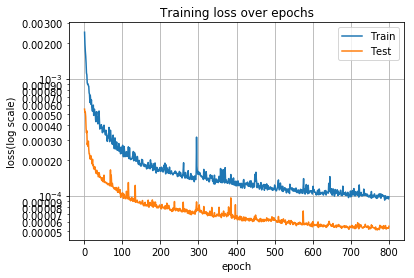

In [16]:
# plot loss over epoch
# Data for plotting
t = np.arange(1, 1+len(list_epoch_loss), 1)
fig, ax = plt.subplots()
plt.yscale('logit')
ax.plot(t, list_epoch_loss, label='Train')
ax.plot(t, list_epoch_loss_test, label='Test')

ax.set(xlabel='epoch', ylabel='loss(log scale)',
       title='Training loss over epochs')
ax.grid()

plt.legend()
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([20, 1, 224, 224])
torch.Size([20, 68, 2])
torch.Size([20, 68, 2])


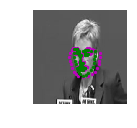

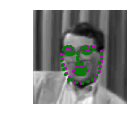

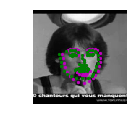

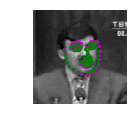

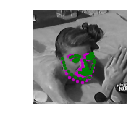

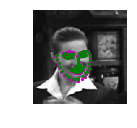

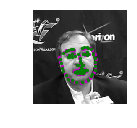

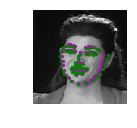

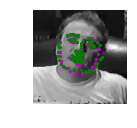

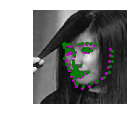

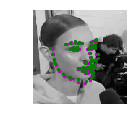

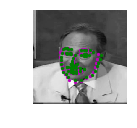

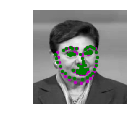

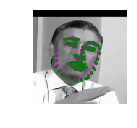

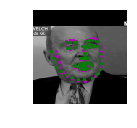

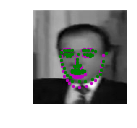

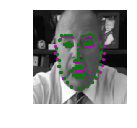

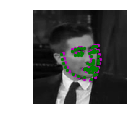

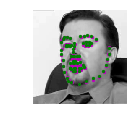

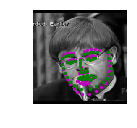

In [18]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images.cpu(), test_outputs.cpu(), gt_pts.cpu(), batch_size)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [19]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_20210401.pt' # 'keypoints_model_20190422.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:

Stochastic Gradient Descent(SGD) is chosen as the optimizer because:

- It is fast in training the network.
- It is simple to implement and robust in real application.

Mean Squared Error(MSE) is chosen as the loss function because:

- MSE is commonly used in regression applications as the loss function.
- The L2 norm accelerates the weight updating on parts of network that account for bigger losses.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:

I start with a architecture similar with the one proposed in [this paper](https://arxiv.org/pdf/1710.00977.pdf).

It is like:
    
    (Conv2D->RELU->Maxpooling->Dropout2D)*4 -> (FCL->RELU->Dropout)*2 -> FCL.
    
Where all the four Conv2D have a 3x3 kernel with stride 1 and padding 1, the dropout ratio increases from 0.1 to 0.6 as the layer gets deeper.

It works but the drawback is that a large number of epochs is needed in order to produce a decent result.

In order to reduce the training time. Three Batch Normalization(BN) layers are inserted into the first three convolutional layers with their dropout layers removed. The final architecture is like:

    (Conv2D->BN2D->RELU->Maxpooling)*3 -> (Conv2D->RELU->Maxpooling->Dropout2D) -> (FCL->RELU->Dropout)*2 -> FCL.
    
This new archtecture saves the training time by half and produce the same decent result.

There is no need to add more convolutional layers or any layers to avoid overfitting the data since dropout layers are aggressively used in this case.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:

Basically I start with a small number of epochs and gradually increase it until the model stops to improve.

A larger batch_size will help to speed up the training of model but on the other hand consume more memory. I have a 1080 ti installed on my local machine so I choose a large batch_size in this case.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.14631499 -0.24501105  0.3171626 ]
 [-0.12413447 -0.12539768 -0.06068403]
 [-0.21189965  0.08914588  0.07810002]]
(3, 3)


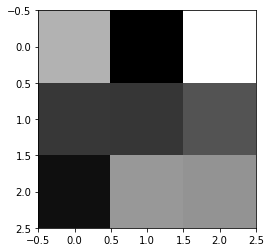

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 3

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

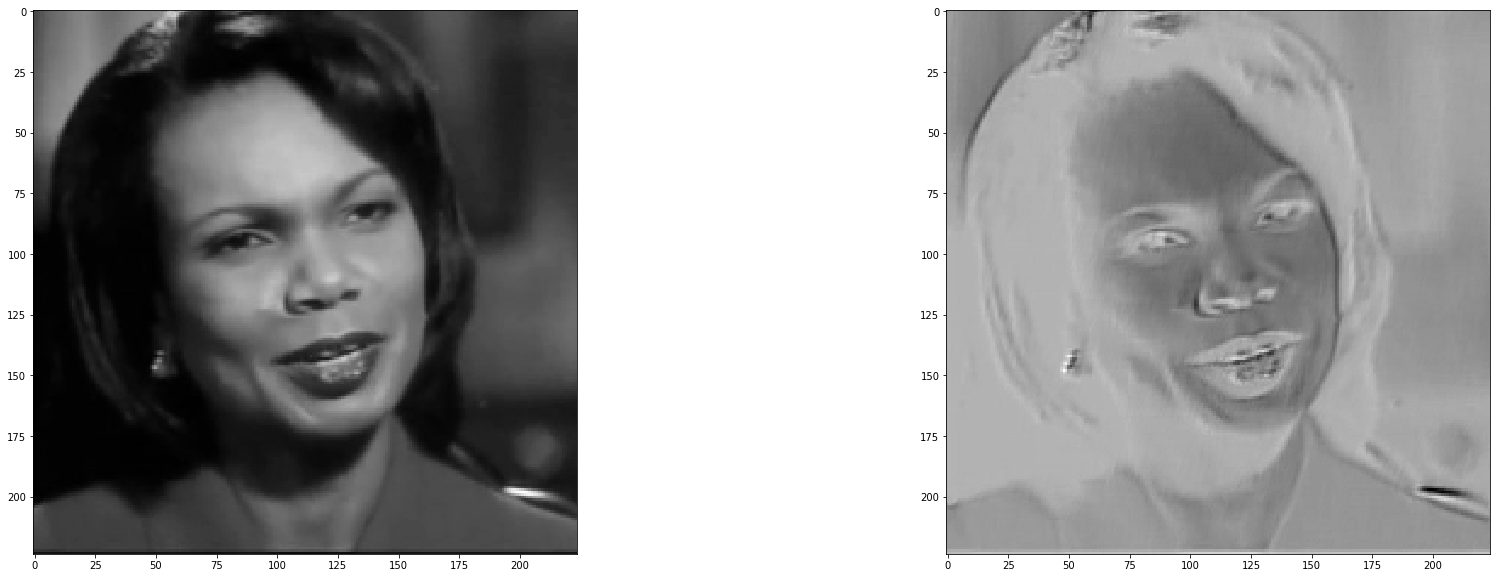

In [21]:
##TODO: load in and display any image from the transformed test dataset
# obtain one batch of testing images
dataiter = iter(test_loader)
images = dataiter.next()['image'].numpy()

# select image by index
idx = 0
img = np.squeeze(images[idx])

# display the original image on the left side
import cv2

fig=plt.figure(figsize=(30, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
c = cv2.filter2D(img, -1, np.squeeze(w[filter_index])) # filtered image
fig.add_subplot(1, 2, 2)
plt.imshow(c, cmap='gray')

plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:

I test the filter with index 3 in the first convolutional layer. It calculates the value difference of pixels in the upper right against those in the lower left in a kernel. This detects features of gradients pointing from lower left to upper right. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!